In [193]:
# # uses table taken from scb excel sheet 2
# df = pd.read_csv('scb_dead_per_age.csv',sep=';',header=None,usecols=range(19),index_col=0)

### ASSUME population for 2020 increases by age group as it did from 2018 to 2019

#### !!!!! ANOMALY in SCB data: historical death data for (at least ) 2019 from statistikdatabasen 
# http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101G/ManadFoddDod/table/tableViewLayout1/
# does not concur with death data 2019 in the preliminary data! 

### DUE to okänd dödsdag when using the daily data of the preliminary stuff - much more okänd dag than okänd månad in 
### the monthly stuff
####

# ALL DATA BASED ON SCB PREL DATA IGNORES THOSE WITH UNKNOWN DAY OF DEATH !!!


##### LESSONS LEARNED :
# 1) DONT SUM AVERAGES : DEATH RATES MUST BE CONVERTED TO ABSOLUTE NUMBERS BEFORE SUMMING AGE CATEGORIES,
#    AND FIRST THEN CONVERT BACK TO NEW RATES !!! EXAMPLE: 100 CATEGORIES OF AGE EACH WITH RATE OF 2% SUMS TO 200%...!

### ASSUMPTIONS : 2020 NR DEATHS WILL GROW LINEARLY DEATHS = (1 / (NR_DATA_DAYS / 365)) * CURRENT_DEATHS

#### POPULATION AGE STRUCTURE FOR 2020 SAME AS FOR 2019

# standardization algorithm from : https://www.healthknowledge.org.uk/e-learning/epidemiology/specialists/standardisation


import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set()

In [194]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=' ')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    
    #df = df.drop('Månad',axis=1)
    
    index = pd.date_range('2020-01-01',periods=len(df))
    df.index = index
    
    known_death_day = df.iloc[:,:7].sum()
    
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] 
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    all_deaths = pd.concat([all_deaths,df['Månad']],axis=1)
    
    return all_deaths

In [195]:
daily_deaths = parse_scb_prel()
year_fraction = len(daily_deaths) / 366

In [196]:
url = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/Dodstal'

data = {
  "query": [
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "4"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [197]:
r = requests.post(url,json=data)
r.status_code

json = r.json()

In [198]:
#parse death data from json to df 

data_list = []

nr_records = (len(json['data']))

for rec in range(nr_records):

    data_list.append ((json['data'][rec]['key'][0],json['data'][rec]['key'][2],json['data'][rec]['values'][0]))

In [199]:
# death rate df from SCB data, deaths per 1000

death_rate = pd.DataFrame(data_list,columns=['age_grp','year','dead_per_1k'])
death_rate

,age_grp,year,dead_per_1k
0,0,2000,3.42
1,0,2001,3.65
2,0,2002,3.27
3,0,2003,3.11
4,0,2004,3.11
...,...,...,...
395,90+,2015,231.68
396,90+,2016,232.57
397,90+,2017,235.55
398,90+,2018,231.67


In [200]:
death_rate['year'] = death_rate['year'].astype(int)
death_rate['dead_per_1k'] = death_rate['dead_per_1k'].astype(float)

# make age_grp categorial for correct sorting
death_rate['age_grp'] = pd.Categorical(death_rate['age_grp'],['0','1-4','5-9','10-14','15-19','20-24','25-29',
                                             '30-34','35-39','40-44','45-49','50-54','55-59',
                                             '60-64','65-69','70-74','75-79','80-84',
                                             '85-89','90+'])


In [201]:
death_rate_idx = ['0','1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                '80-84','85-89','90+']

In [202]:
#pivot for easier handling
death_rate = pd.pivot(death_rate,index='year',columns='age_grp',values='dead_per_1k')
death_rate = death_rate.T

death_rate.index = death_rate_idx
death_rate

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,3.42,3.65,3.27,3.11,3.11,2.43,2.80,2.49,2.49,2.49,2.54,2.10,2.59,2.69,2.18,2.45,2.49,2.41,2.03,2.07
1-4,0.12,0.19,0.19,0.20,0.13,0.21,0.17,0.17,0.14,0.20,0.15,0.13,0.13,0.11,0.11,0.13,0.13,0.10,0.14,0.12
5-9,0.10,0.09,0.07,0.09,0.09,0.10,0.09,0.09,0.06,0.09,0.06,0.09,0.07,0.06,0.07,0.07,0.08,0.06,0.05,0.05
10-14,0.13,0.12,0.11,0.10,0.10,0.10,0.09,0.08,0.11,0.11,0.09,0.09,0.10,0.08,0.07,0.11,0.08,0.09,0.11,0.07
15-19,0.36,0.30,0.33,0.34,0.32,0.26,0.31,0.32,0.29,0.27,0.27,0.28,0.24,0.24,0.24,0.23,0.20,0.24,0.25,0.24
20-24,0.51,0.52,0.53,0.48,0.55,0.47,0.50,0.47,0.48,0.45,0.46,0.44,0.43,0.43,0.45,0.46,0.38,0.43,0.48,0.45
25-29,0.50,0.46,0.45,0.47,0.48,0.50,0.43,0.50,0.53,0.47,0.50,0.49,0.48,0.54,0.49,0.55,0.50,0.55,0.50,0.47
30-34,0.52,0.56,0.55,0.50,0.48,0.49,0.50,0.48,0.54,0.48,0.50,0.53,0.49,0.52,0.62,0.55,0.58,0.55,0.55,0.50
35-39,0.82,0.81,0.72,0.74,0.69,0.70,0.70,0.68,0.63,0.69,0.57,0.62,0.67,0.65,0.56,0.61,0.65,0.64,0.62,0.63
40-44,1.24,1.23,1.21,1.22,1.11,1.09,1.07,1.06,1.07,1.02,0.91,0.91,0.88,0.88,0.92,0.85,0.89,0.90,0.87,0.86


0          3.65
1-4        0.21
5-9        0.10
10-14      0.13
15-19      0.36
20-24      0.55
25-29      0.55
30-34      0.62
35-39      0.82
40-44      1.24
45-49      2.16
50-54      3.39
55-59      5.41
60-64      8.83
65-69     14.27
70-74     24.02
75-79     41.38
80-84     73.96
85-89    133.57
90+      256.59
dtype: float64 0         1
1-4       5
5-9       0
10-14     0
15-19     0
20-24     4
25-29    15
30-34    14
35-39     0
40-44     0
45-49     1
50-54     0
55-59     1
60-64     0
65-69     0
70-74     0
75-79     0
80-84     0
85-89     2
90+       2
dtype: int64


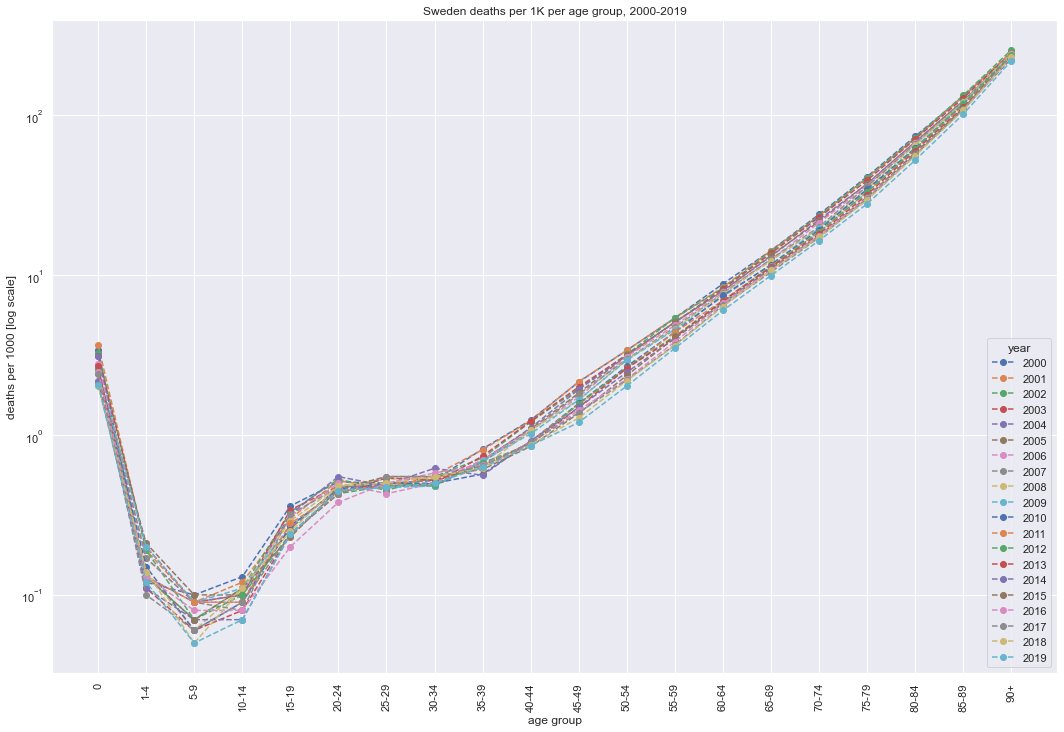

In [203]:
# Darwin awards to young males.....

# max deathrate and corresponding column index 

print(death_rate.max(axis=1),death_rate.apply(lambda row: np.argmax(row),axis=1))

death_rate.plot(figsize=(18,12),style='o--',title='Sweden deaths per 1K per age group, 2000-2019')
plt.xlabel('age group')
plt.ylabel('deaths per 1000 [log scale]')
plt.yscale('log')
_= plt.xticks(range(len(death_rate)),death_rate.index.values,rotation=90)

In [204]:
# fetch population data

url2 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101A/BefolkningR1860'
data2 = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "agg:Ålder5år",
        "values": [
          "-4",
          "5-9",
          "10-14",
          "15-19",
          "20-24",
          "25-29",
          "30-34",
          "35-39",
          "40-44",
          "45-49",
          "50-54",
          "55-59",
          "60-64",
          "65-69",
          "70-74",
          "75-79",
          "80-84",
          "85-89",
          "90-94",
          "95-99",
          "100+"
        ]
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2000",
          "2001",
          "2002",
          "2003",
          "2004",
          "2005",
          "2006",
          "2007",
          "2008",
          "2009",
          "2010",
          "2011",
          "2012",
          "2013",
          "2014",
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}


In [205]:
r2 = requests.post(url2,json=data2)
print (r2.status_code)
json2 = r2.json()

200


In [206]:
#parse population data

data_list2 = []

nr_records2 = (len(json2['data']))

for rec2 in range(nr_records2):

    data_list2.append ((json2['data'][rec2]['key'][0],
                        json2['data'][rec2]['key'][1],json2['data'][rec2]['key'][2],json2['data'][rec2]['values'][0]))


In [207]:
# put pop.data into df2

population = pd.DataFrame(data_list2,columns=['age_grp','gender','year','pop'])
population['year'] = population['year'].astype(int)
population['pop'] = population['pop'].astype(int)



In [208]:
# make age_grp categorical for correct sort order
population['age_grp'] = pd.Categorical(population['age_grp'],['-4','5-9','10-14','15-19','20-24','25-29',
                                               '30-34','35-39','40-44','45-49','50-54',
                                               '55-59','60-64','65-69','70-74','75-79',
                                               '80-84','85-89','90-94','95-99','100+'])

population

,age_grp,gender,year,pop
0,-4,1,2000,234890
1,-4,1,2001,234235
2,-4,1,2002,237592
3,-4,1,2003,242795
4,-4,1,2004,249343
...,...,...,...,...
835,100+,2,2015,1581
836,100+,2,2016,1649
837,100+,2,2017,1732
838,100+,2,2018,1705


In [209]:
# sum male + female by grouping 
population = population.groupby(['age_grp','year']).sum()
population = population.unstack()
population = population.droplevel(0,axis=1)

population_idx = ['1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                '80-84','85-89','90-94','95-99','100+']

population.index = population_idx
population

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
1-4,457850,455767,462499,472886,485558,496345,512583,525305,536982,548222,561788,567369,573583,579019,584157,586218,597041,602044,604498,601718
5-9,585912,557400,527036,501599,479919,468687,468021,476238,488735,503934,515657,530937,543993,557950,571614,589118,600853,612180,619473,624084
10-14,587036,607108,622390,624505,618104,595744,568983,540190,516685,497286,487514,485964,494283,509132,526262,541807,563100,580453,595758,609019
15-19,508580,519061,532226,553300,574697,598380,619722,637028,641408,638533,618605,592376,564627,543627,527236,522472,529612,544838,559513,568909
20-24,516722,515633,517004,520017,522312,527268,541577,557526,580335,605453,632016,650862,667153,671940,671529,656448,640179,616919,597593,587699
25-29,592158,580920,568748,555951,545719,544061,547734,554452,562889,571759,581923,595136,609060,631255,655755,682413,711687,734003,741322,739696
30-34,627790,619124,611611,609103,612637,610276,602045,593201,585237,580069,581869,585111,591487,599989,609378,619071,641176,662493,690141,715891
35-39,632088,651076,664918,665896,651152,638015,631447,626492,626711,634498,633882,625948,616777,608912,604368,608570,617317,628193,640119,650598
40-44,584563,583214,586350,596567,615765,636164,656262,671687,674250,663060,652226,645713,640696,641199,650114,651944,647816,641675,635836,631263
45-49,583580,585599,586474,584872,586438,584853,584445,588628,600199,621146,642527,662411,677490,681129,670744,662423,658991,656677,658339,667092


In [210]:
population.sum()


year
2000     8882792
2001     8909128
2002     8940788
2003     8975670
2004     9011392
2005     9047752
2006     9113257
2007     9182927
2008     9256347
2009     9340682
2010     9415570
2011     9482855
2012     9555893
2013     9644864
2014     9747355
2015     9851017
2016     9995153
2017    10120242
2018    10230185
2019    10327589
dtype: int64

In [211]:
# in order to compare with death rates, where 0-year old are separate, and highest cat is 90+,
# must do some restructruring of age groups

In [212]:
# new index to confirm with death rates

population_idx = ['1-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39',
                '40-44','45-49','50-54','55-59','60-64','65-69','70-74','75-79',
                '80-84','85-89','90+']

# merge the 90-94,95-99 and 100+ groups to 90+

pop_90_plus = population.iloc[-3:].sum()
population = population.drop(['90-94','95-99','100+'])
population = population.append(pop_90_plus,ignore_index=True)
population.index = population_idx


In [213]:
# born under the year - find the 0-years old

url3 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101H/FoddaK'

data3 = {
  "query": [
    {
      "code": "Region",
      "selection": {
        "filter": "vs:RegionRiket99",
        "values": []
      }
    },
    {
      "code": "AlderModer",
      "selection": {
        "filter": "vs:ÅlderTotA",
        "values": []
      }
    },
    {
      "code": "Kon",
      "selection": {
        "filter": "item",
        "values": [
          "1",
          "2"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2000",
          "2001",
          "2002",
          "2003",
          "2004",
          "2005",
          "2006",
          "2007",
          "2008",
          "2009",
          "2010",
          "2011",
          "2012",
          "2013",
          "2014",
          "2015",
          "2016",
          "2017",
          "2018",
          "2019"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [214]:
r3 = requests.post(url3,json=data3)
print (r3.status_code)
json3 = r3.json()

200


In [215]:
#parse population data

data_list3 = []

nr_records3 = (len(json3['data']))

for rec3 in range(nr_records3):

    data_list3.append ((json3['data'][rec3]['key'][0],
                        json3['data'][rec3]['key'][1],json3['data'][rec3]['values'][0]))


In [216]:
# put pop.data into df2

births = pd.DataFrame(data_list3,columns=['gender','year','0'])
births['year'] = births['year'].astype(int)
births['0'] = births['0'].astype(int)

births

,gender,year,0
0,1,2000,46620
1,1,2001,47138
2,1,2002,49187
3,1,2003,51114
4,1,2004,51975
5,1,2005,52036
6,1,2006,54483
7,1,2007,55259
8,1,2008,56352
9,1,2009,57564


In [217]:
# add boys + girls

births = (births.groupby(['year']).sum()).T
births.index.name='age_grp'
births

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
age_grp,,,,,,,,,,,,,,,,,,,,
0,90441,91466,95815,99157,100928,101346,105913,107421,109301,111801,115641,111770,113177,113593,114907,114870,117425,115416,115832,114523


In [218]:
# add zero years old to top of population, subtract z-years from 1-4
population = pd.concat([births,population],axis=0)
population.loc['1-4',:] = population.loc['1-4',:] - population.loc['0',:]
population


year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,90441,91466,95815,99157,100928,101346,105913,107421,109301,111801,115641,111770,113177,113593,114907,114870,117425,115416,115832,114523
1-4,367409,364301,366684,373729,384630,394999,406670,417884,427681,436421,446147,455599,460406,465426,469250,471348,479616,486628,488666,487195
5-9,585912,557400,527036,501599,479919,468687,468021,476238,488735,503934,515657,530937,543993,557950,571614,589118,600853,612180,619473,624084
10-14,587036,607108,622390,624505,618104,595744,568983,540190,516685,497286,487514,485964,494283,509132,526262,541807,563100,580453,595758,609019
15-19,508580,519061,532226,553300,574697,598380,619722,637028,641408,638533,618605,592376,564627,543627,527236,522472,529612,544838,559513,568909
20-24,516722,515633,517004,520017,522312,527268,541577,557526,580335,605453,632016,650862,667153,671940,671529,656448,640179,616919,597593,587699
25-29,592158,580920,568748,555951,545719,544061,547734,554452,562889,571759,581923,595136,609060,631255,655755,682413,711687,734003,741322,739696
30-34,627790,619124,611611,609103,612637,610276,602045,593201,585237,580069,581869,585111,591487,599989,609378,619071,641176,662493,690141,715891
35-39,632088,651076,664918,665896,651152,638015,631447,626492,626711,634498,633882,625948,616777,608912,604368,608570,617317,628193,640119,650598
40-44,584563,583214,586350,596567,615765,636164,656262,671687,674250,663060,652226,645713,640696,641199,650114,651944,647816,641675,635836,631263


In [219]:
# check for correct totals

population.sum()

year
2000     8882792
2001     8909128
2002     8940788
2003     8975670
2004     9011392
2005     9047752
2006     9113257
2007     9182927
2008     9256347
2009     9340682
2010     9415570
2011     9482855
2012     9555893
2013     9644864
2014     9747355
2015     9851017
2016     9995153
2017    10120242
2018    10230185
2019    10327589
dtype: int64

In [220]:
#yby_pop_increase = population.sum() / (population.sum()).shift()
#yby_pop_increase
yby_age_increase = population.T / population.T.shift()
yby_age_increase


,0,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90+
year,,,,,,,,,,,,,,,,,,,,
2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001,1.011333,0.991541,0.951337,1.034192,1.020608,0.997892,0.981022,0.986196,1.030040,0.997692,1.003460,0.971525,1.054494,1.028476,1.005340,0.989930,0.973828,1.035918,1.006681,1.027958
2002,1.047548,1.006541,0.945526,1.025172,1.025363,1.002659,0.979047,0.987865,1.021260,1.005377,1.001494,0.975545,1.029075,1.049886,1.011079,0.994649,0.982139,1.012367,1.004455,1.022630
2003,1.034880,1.019213,0.951736,1.003398,1.039596,1.005828,0.977500,0.995899,1.001471,1.017425,0.997268,0.978275,1.010765,1.059222,1.029090,0.982850,0.987552,1.013622,1.006140,1.029296
2004,1.017861,1.029168,0.956778,0.989750,1.038672,1.004413,0.981596,1.005802,0.977858,1.032181,1.002678,0.980458,0.991145,1.064042,1.034298,0.993710,0.985325,1.009457,1.011123,1.033015
2005,1.004142,1.026958,0.976596,0.963825,1.041210,1.009489,0.996962,0.996146,0.979825,1.033128,0.997297,0.991830,0.981011,1.064622,1.026910,0.993745,0.991674,0.975681,1.069973,1.016803
2006,1.045063,1.029547,0.998579,0.955080,1.035666,1.027138,1.006751,0.986513,0.989706,1.031592,0.999302,1.004279,0.972045,1.055064,1.029251,1.008031,0.993258,0.979130,1.045296,1.020671
2007,1.014238,1.027575,1.017557,0.949396,1.027925,1.029449,1.012265,0.985310,0.992153,1.023504,1.007157,1.002592,0.976185,1.029518,1.050703,1.014450,0.997728,0.987625,1.015655,1.017607
2008,1.017501,1.023444,1.026241,0.956488,1.006876,1.040911,1.015217,0.986575,1.000350,1.003816,1.019658,0.998744,0.979347,1.011492,1.060145,1.031874,0.986750,0.991758,1.019423,1.013571


In [221]:
max_age_increase = yby_age_increase.max(axis=1)
max_age_increase_idx =yby_age_increase.apply(np.argmax,axis=1)


In [222]:
age_increase_2019 = yby_age_increase.loc[2019]
age_increase_2019

0        0.988699
1-4      0.996990
5-9      1.007443
10-14    1.022259
15-19    1.016793
20-24    0.983444
25-29    0.997807
30-34    1.037311
35-39    1.016370
40-44    0.992808
45-49    1.013296
50-54    0.985325
55-59    1.035296
60-64    1.005882
65-69    0.983137
70-74    0.994264
75-79    1.069839
80-84    1.044060
85-89    1.008170
90+      1.013469
Name: 2019, dtype: float64

In [223]:
### ASSUME population for 2020 increases by age group as it did from 2018 to 2019
pop_2020 = population[2019] * age_increase_2019
population[2020] = pop_2020.astype(int)
#population
population.sum()

year
2000     8882792
2001     8909128
2002     8940788
2003     8975670
2004     9011392
2005     9047752
2006     9113257
2007     9182927
2008     9256347
2009     9340682
2010     9415570
2011     9482855
2012     9555893
2013     9644864
2014     9747355
2015     9851017
2016     9995153
2017    10120242
2018    10230185
2019    10327589
2020    10430517
dtype: int64

In [224]:
medel_pop = (population.T + population.T.shift()) / 2 #snittet av två påföljande år
medel_pop = medel_pop.T
medel_pop = medel_pop.drop(2000,axis=1)

# use the official population average of two consequtive years; drop column 2000 in death rate also

#### CHANGING POPULATION to official AVERAGE population! 
population = medel_pop
####

death_rate = death_rate.drop(2000,axis=1)

In [225]:
population.sum()

year
2001     8895960.0
2002     8924958.0
2003     8958229.0
2004     8993531.0
2005     9029572.0
2006     9080504.5
2007     9148092.0
2008     9219637.0
2009     9298514.5
2010     9378126.0
2011     9449212.5
2012     9519374.0
2013     9600378.5
2014     9696109.5
2015     9799186.0
2016     9923085.0
2017    10057697.5
2018    10175213.5
2019    10278887.0
2020    10379053.0
dtype: float64

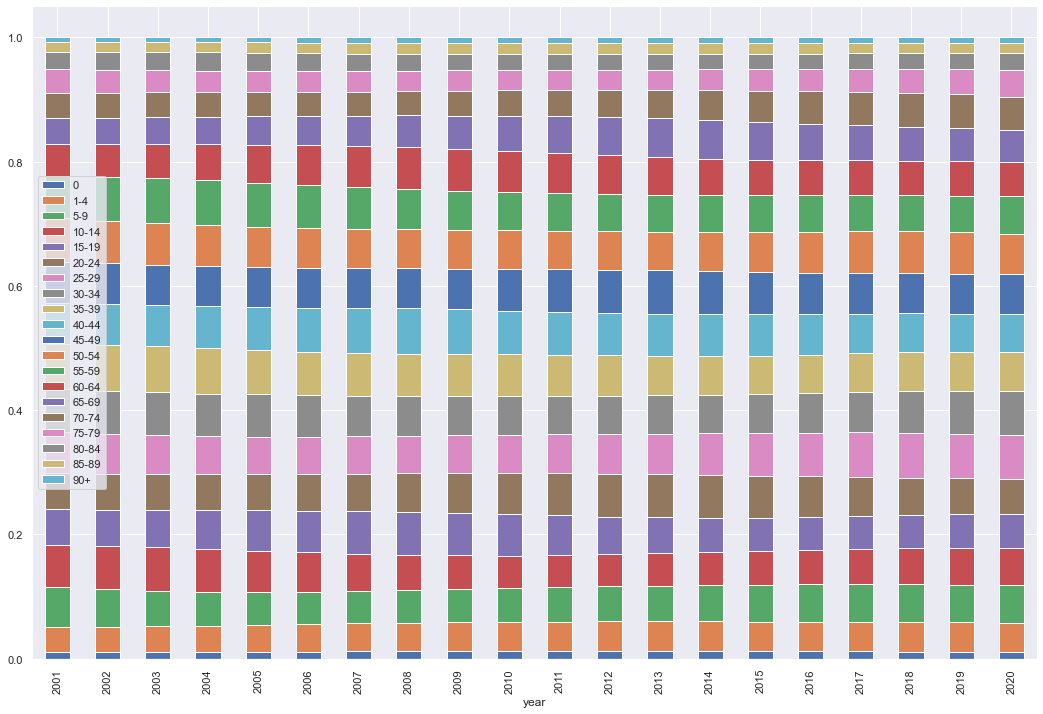

In [226]:
(population / population.sum()).T.plot(kind='bar',stacked=True,figsize=(18,12))

In [227]:
# table taken from scb excel sheet 2
# to get 2020 deaths

age_df = pd.read_csv('scb_dead_per_age.csv',sep=';',header=None,usecols=range(19),index_col=0)

cols = ['2019_tot','2019_M_64','2019_M_79','2019_M_89','2019_M_90+',
       '2019_W_64','2019_W_79','2019_W_89','2019_W_90+',
       '2020_tot','2020_M_64','2020_M_79','2020_M_89','2020_M_90+',
       '2020_W_64','2020_W_79','2020_W_89','2020_W_90+']

index = pd.date_range('2020-01-01','2021-01-01')
age_df.index = index
age_df.columns = cols
age_df

,2019_tot,2019_M_64,2019_M_79,2019_M_89,2019_M_90+,2019_W_64,2019_W_79,2019_W_89,2019_W_90+,2020_tot,2020_M_64,2020_M_79,2020_M_89,2020_M_90+,2020_W_64,2020_W_79,2020_W_89,2020_W_90+
2020-01-01,300,20,48,56,32,12,39,46,47,254,14,40,47,16,16,30,50,41
2020-01-02,276,25,33,48,24,13,28,57,48,300,20,49,36,29,13,47,51,55
2020-01-03,271,13,41,48,22,9,38,49,51,256,13,26,49,23,2,35,47,61
2020-01-04,282,17,48,52,28,14,39,57,27,272,14,37,43,21,15,40,45,57
2020-01-05,275,21,37,52,28,11,34,52,40,265,10,41,49,18,9,38,46,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,215,15,50,23,18,10,20,43,36,0,0,0,0,0,0,0,0,0
2020-12-29,244,11,50,52,20,7,23,44,37,0,0,0,0,0,0,0,0,0
2020-12-30,226,15,39,41,21,12,31,29,38,0,0,0,0,0,0,0,0,0
2020-12-31,246,22,43,39,22,12,32,41,35,0,0,0,0,0,0,0,0,0


In [228]:
monthly = age_df.resample('M').sum()
monthly

,2019_M_64,2019_M_79,2019_M_89,2019_M_90+,2019_W_64,2019_W_79,2019_W_89,2019_W_90+,2020_M_64,2020_M_79,2020_M_89,2020_M_90+,2020_W_64,2020_W_79,2020_W_89,2020_W_90+
2020-01-31,540,1340,1421,760,340,982,1461,1330,494,1297,1417,754,328,1003,1442,1385
2020-02-29,488,1230,1249,602,274,876,1329,1246,438,1201,1330,661,316,894,1305,1217
2020-03-31,462,1280,1319,628,307,973,1319,1282,495,1400,1528,718,348,1007,1473,1395
2020-04-30,438,1172,1247,630,305,857,1321,1216,618,1746,1938,946,318,1179,1915,1707
2020-05-31,420,1168,1173,597,307,872,1255,1180,556,1471,1523,796,312,1013,1595,1434
2020-06-30,439,1134,1044,539,287,833,1132,1044,488,1229,1294,621,284,867,1254,1179
2020-07-31,443,1170,1098,565,290,909,1208,1040,435,1146,1159,560,293,864,1175,1059
2020-08-31,428,1142,1170,576,298,821,1242,1152,44,131,131,74,33,111,157,129
2020-09-30,431,1207,1171,561,317,800,1169,1018,0,0,0,0,0,0,0,0
2020-10-31,428,1282,1281,690,345,916,1227,1169,0,0,0,0,0,0,0,0


In [229]:

monthly.sum()



2019_M_64      6161
2019_M_79     15312
2019_M_89     15040
2019_M_90+     7513
2019_W_64      3978
2019_W_79     10967
2019_W_89     15554
2019_W_90+    14241
2020_M_64      3993
2020_M_79     10072
2020_M_89     10452
2020_M_90+     5152
2020_W_64      2372
2020_W_79      7122
2020_W_89     10422
2020_W_90+     9549
dtype: int64

In [230]:



#monthly.drop(['2019_tot','2020_tot'],axis=1,inplace=True)
monthly_sums_per_age = monthly.sum()
cols = ['2019_M_64','2020_M_64','2019_M_79','2020_M_79','2019_M_89','2020_M_89','2019_M_90+','2020_M_90+',
        '2019_W_64','2020_W_64','2019_W_79','2020_W_79','2019_W_89','2020_W_89','2019_W_90+','2020_W_90+']

monthly_sums_per_age = monthly_sums_per_age[cols]

foo = monthly_sums_per_age.index.str.contains('W')

monthly_sums_per_age = pd.DataFrame(monthly_sums_per_age,columns=['dead'])


monthly_sums_per_age['female'] = foo


monthly_sums_per_age.reset_index(inplace=True,drop=False)

bar = monthly_sums_per_age['index'].str[-3:].str.replace('_','').str.replace('+','').astype(int)

monthly_sums_per_age['age'] = bar

monthly_sums_per_age['year'] = monthly_sums_per_age['index'].apply(lambda x : x[:4])
monthly_sums_per_age['year'] = monthly_sums_per_age['year'].apply(lambda x : pd.Timestamp(x).year)
monthly_sums_per_age['gender'] = monthly_sums_per_age['female'].apply(lambda x : 'F' if x == True else 'M')
monthly_sums_per_age.index = monthly_sums_per_age[['year','gender','age']]

monthly_sums_per_age = monthly_sums_per_age.groupby(['year','age'])['dead'].sum()
deaths_2020_ytd = monthly_sums_per_age.unstack()
deaths_2020_ytd = deaths_2020_ytd.drop(2019).T

deaths_2020_ytd = deaths_2020_ytd * ( 1 / year_fraction)
print (deaths_2020_ytd)
print (deaths_2020_ytd.sum())

year          2020
age               
64    10589.045455
79    28604.563636
89    34726.745455
90    24457.118182
year
2020    98377.472727
dtype: float64


In [231]:
# CALCULATE ABSOLUTE YEARLY DEATHS FROM POPULATION x DEATH RATE - 2020 forecasted 
absolute_deaths = (death_rate / 1000 * population).astype(int,errors='ignore')
print (absolute_deaths.sum())


year
2001    93750.326040
2002    94994.365200
2003    92958.644245
2004    90532.655580
2005    91706.505400
2006    91159.482065
2007    91726.822575
2008    91443.455250
2009    90063.385025
2010    90482.835325
2011    89940.926050
2012    91940.199595
2013    90393.007040
2014    88976.826860
2015    90924.676100
2016    90977.486605
2017    91970.280935
2018    92192.340995
2019    88771.530085
2020        0.000000
dtype: float64


In [232]:
# stratify absolute deaths into 4 age groups

abs_deaths_64 = absolute_deaths.loc[:'60-64'].sum()
abs_deaths_79 = absolute_deaths.loc['65-69' : '75-79'].sum()
abs_deaths_89 = absolute_deaths.loc['80-84': '85-89'].sum()
abs_deaths_90 = absolute_deaths.loc['90+']

strata_abs_deaths = pd.concat([abs_deaths_64,abs_deaths_79,abs_deaths_89,abs_deaths_90],axis=1)
strata_abs_deaths.columns = ['64','79','89','90+']

strata_abs_deaths.loc[2020,:] = deaths_2020_ytd.T.values

strata_abs_deaths = strata_abs_deaths.astype(int)
print (strata_abs_deaths.sum(axis=1))
strata_abs_deaths

year
2001    93748
2002    94991
2003    92957
2004    90530
2005    91704
2006    91157
2007    91726
2008    91441
2009    90061
2010    90481
2011    89940
2012    91938
2013    90391
2014    88974
2015    90922
2016    90976
2017    91969
2018    92190
2019    88770
2020    98376
dtype: int64


,64,79,89,90+
year,,,,
2001,13267,27436,36600,16445
2002,13105,26995,37508,17383
2003,13090,26098,36751,17018
2004,13062,24866,35692,16910
2005,13102,24758,36190,17654
2006,13037,24041,36080,17999
2007,12944,23765,36351,18666
2008,12853,23501,36201,18886
2009,12561,23451,35431,18618


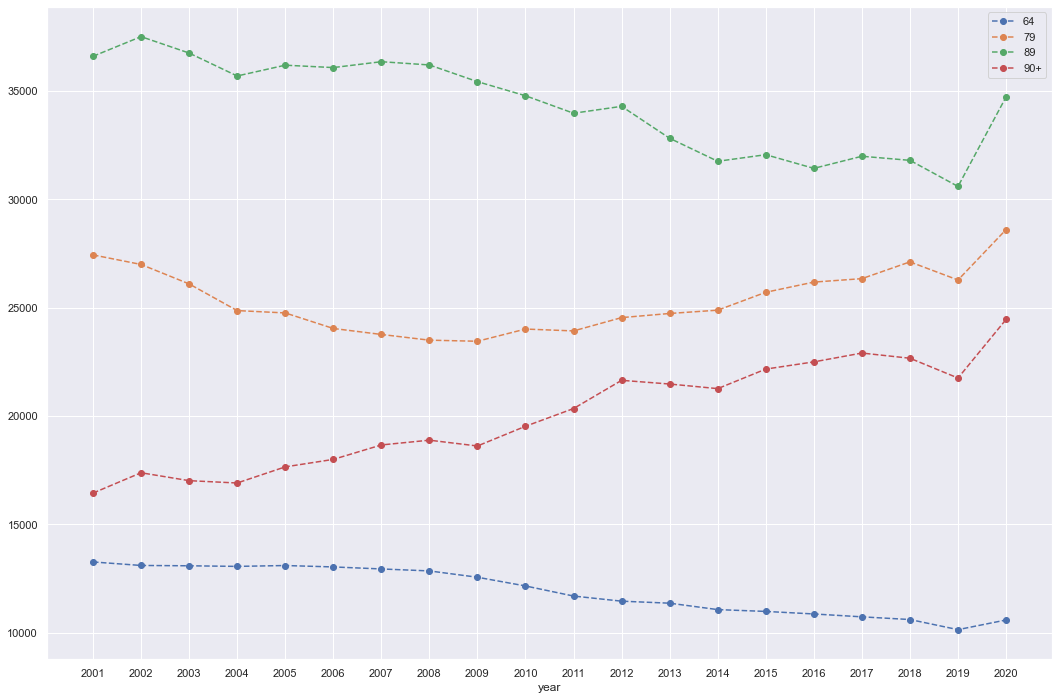

In [233]:
strata_abs_deaths.plot(figsize=(18,12),style='o--')
_= plt.xticks(range(2001,2021))

In [234]:
# stratify population to 4 age groups

abs_pop_64 = population.loc[:'60-64'].sum()
abs_pop_79 = population.loc['65-69' : '75-79'].sum()
abs_pop_89 = population.loc['80-84' : '85-89'].sum()
abs_pop_90 = population.loc['90+']

strata_abs_pop = pd.concat([abs_pop_64,abs_pop_79,abs_pop_89,abs_pop_90],axis=1)
strata_abs_pop.columns = ['64','79','89','90+']
strata_abs_pop

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0
2006,7507097.5,1084698.5,413877.0,74831.5
2007,7553167.0,1104317.0,414345.5,76262.5
2008,7592890.0,1134709.5,414587.5,77450.0
2009,7630585.5,1174180.0,414772.5,78976.5


In [235]:
strata_abs_pop.sum(axis=1)

year
2001     8895960.0
2002     8924958.0
2003     8958229.0
2004     8993531.0
2005     9029572.0
2006     9080504.5
2007     9148092.0
2008     9219637.0
2009     9298514.5
2010     9378126.0
2011     9449212.5
2012     9519374.0
2013     9600378.5
2014     9696109.5
2015     9799186.0
2016     9923085.0
2017    10057697.5
2018    10175213.5
2019    10278887.0
2020    10379053.0
dtype: float64

In [236]:
# compute stratified per capita death rates

computed_death_rate_per_capita = strata_abs_deaths / strata_abs_pop
computed_death_rate_per_capita 


,64,79,89,90+
year,,,,
2001,0.001801,0.025567,0.093294,0.248865
2002,0.001773,0.025322,0.093977,0.256579
2003,0.001764,0.024510,0.091143,0.244826
2004,0.001754,0.023268,0.087596,0.235916
2005,0.001754,0.023028,0.087990,0.240341
2006,0.001737,0.022164,0.087176,0.240527
2007,0.001714,0.021520,0.087731,0.244760
2008,0.001693,0.020711,0.087318,0.243848
2009,0.001646,0.019972,0.085423,0.235741


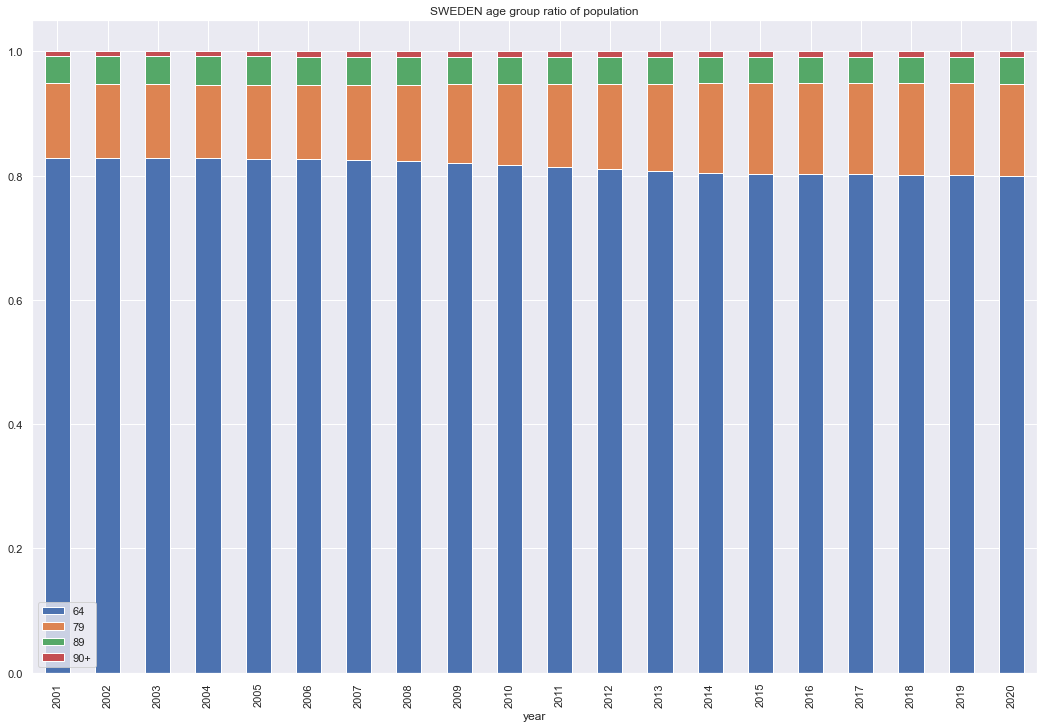

In [237]:
(strata_abs_pop.div(strata_abs_pop.sum(axis=1),axis=0)).plot(kind='bar',title='SWEDEN age group ratio of population',
                                                             stacked=True,figsize=(18,12))

In [238]:
# death rate YBY change

stratified_yearly_death_rate_per_capita_YBY_change = computed_death_rate_per_capita / computed_death_rate_per_capita.shift()
stratified_yearly_death_rate_per_capita_YBY_change

,64,79,89,90+
year,,,,
2001,NaN,NaN,NaN,NaN
2002,0.984109,0.990413,1.007315,1.030998
2003,0.994995,0.967923,0.969850,0.954193
2004,0.994506,0.949348,0.961083,0.963606
2005,0.999842,0.989684,1.004495,1.018755
2006,0.990084,0.962452,0.990743,1.000775
2007,0.986811,0.970958,1.006372,1.017598
2008,0.987775,0.962404,0.995292,0.996273
2009,0.972454,0.964329,0.978293,0.966755


In [239]:
# calculate avg 2015-2019 death rate

stratified_avg_death_rate_2015_2019 = computed_death_rate_per_capita.loc[2015:2019].mean()
stratified_avg_death_rate_2015_2019

64     0.001325
79     0.017806
89     0.076150
90+    0.230255
dtype: float64

In [240]:
# factor death yearly death rates vs avg 2015-2019

stratified_death_rate_vs_avg_2015_2019 = computed_death_rate_per_capita / stratified_avg_death_rate_2015_2019

stratified_death_rate_vs_avg_2015_2019

,64,79,89,90+
year,,,,
2001,1.359520,1.435903,1.225133,1.080824
2002,1.337915,1.422136,1.234095,1.114328
2003,1.331220,1.376519,1.196887,1.063284
2004,1.323906,1.306795,1.150308,1.024587
2005,1.323697,1.293315,1.155478,1.043804
2006,1.310572,1.244754,1.144782,1.044612
2007,1.293286,1.208604,1.152077,1.062996
2008,1.277476,1.163166,1.146653,1.059034
2009,1.242286,1.121674,1.121763,1.023827


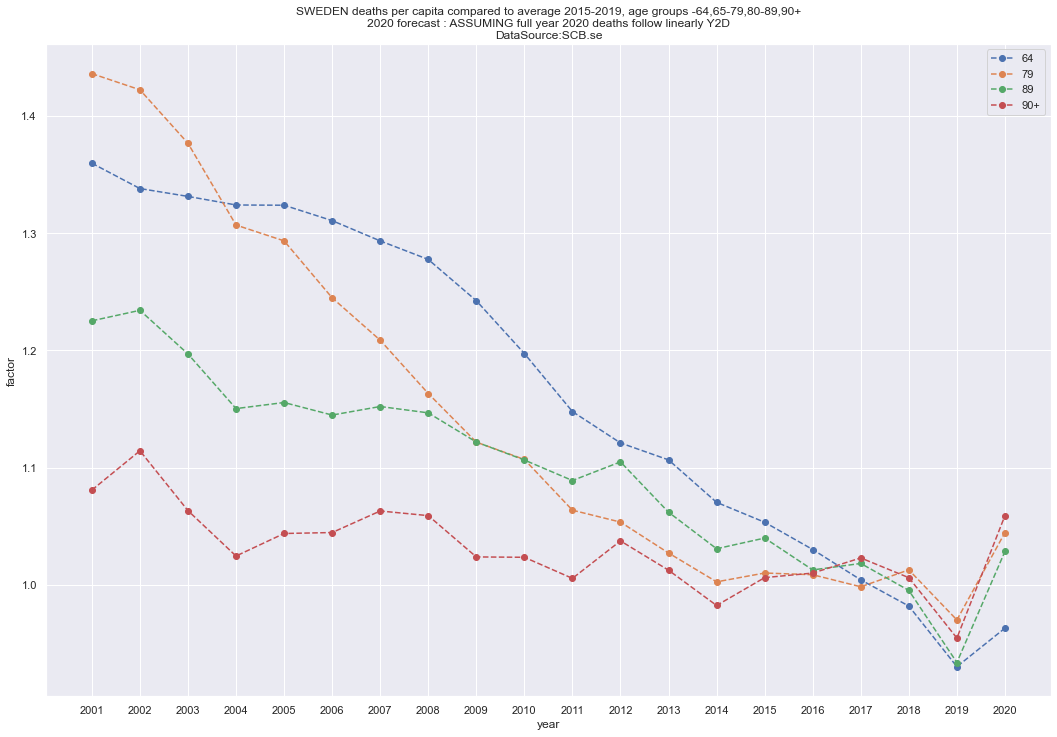

In [241]:
title = 'SWEDEN deaths per capita compared to average 2015-2019, age groups -64,65-79,80-89,90+\n'\
'2020 forecast : ASSUMING full year 2020 deaths follow linearly Y2D\nDataSource:SCB.se'

stratified_death_rate_vs_avg_2015_2019.plot(figsize=(18,12),
                                            style='o--',title=title)
plt.xticks(range(2001,2021))
plt.ylabel('factor')
plt.savefig('death_rate_trend.jpg',format='jpg')

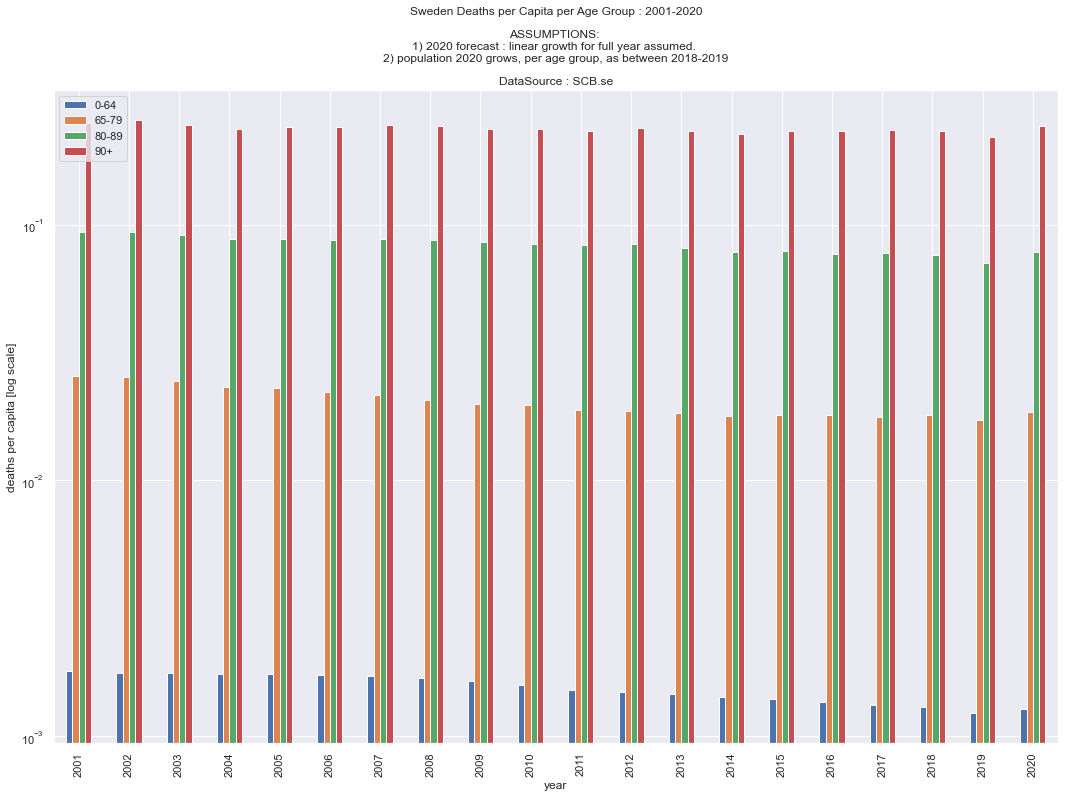

In [242]:
title = 'Sweden Deaths per Capita per Age Group : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) 2020 forecast : linear growth for full year assumed. \n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'

(computed_death_rate_per_capita).plot(kind='bar',
                                    figsize=(18,12),
                                      title=title)
plt.yscale('log')
plt.ylabel('deaths per capita [log scale]')
plt.legend(['0-64','65-79','80-89','90+'])
plt.savefig('age_adj_death_ratio_1.jpg',format='jpg')


In [243]:
per_M_ylim = [0,14000]

            64        79        89       90+
year                                        
2001  0.001801  0.025567  0.093294  0.248865
2002  0.001773  0.025322  0.093977  0.256579
2003  0.001764  0.024510  0.091143  0.244826
2004  0.001754  0.023268  0.087596  0.235916
2005  0.001754  0.023028  0.087990  0.240341
2006  0.001737  0.022164  0.087176  0.240527
2007  0.001714  0.021520  0.087731  0.244760
2008  0.001693  0.020711  0.087318  0.243848
2009  0.001646  0.019972  0.085423  0.235741
2010  0.001586  0.019710  0.084257  0.235669
2011  0.001521  0.018939  0.082925  0.231529
2012  0.001485  0.018759  0.084137  0.238885
2013  0.001466  0.018289  0.080868  0.233133
2014  0.001418  0.017852  0.078496  0.226210
2015  0.001396  0.017986  0.079190  0.231680
2016  0.001365  0.017960  0.077121  0.232569
2017  0.001331  0.017777  0.077541  0.235544
2018  0.001301  0.018034  0.075792  0.231666
2019  0.001233  0.017273  0.071109  0.219815
2020  0.001276  0.018600  0.078324  0.243845


year
2001    93748.0
2002    94991.0
2003    92957.0
2004    90530.0
2005    91704.0
2006    91157.0
2007    91726.0
2008    91441.0
2009    90061.0
2010    90481.0
2011    89940.0
2012    91938.0
2013    90391.0
2014    88974.0
2015    90922.0
2016    90976.0
2017    91969.0
2018    92190.0
2019    88770.0
2020    98376.0
dtype: float64

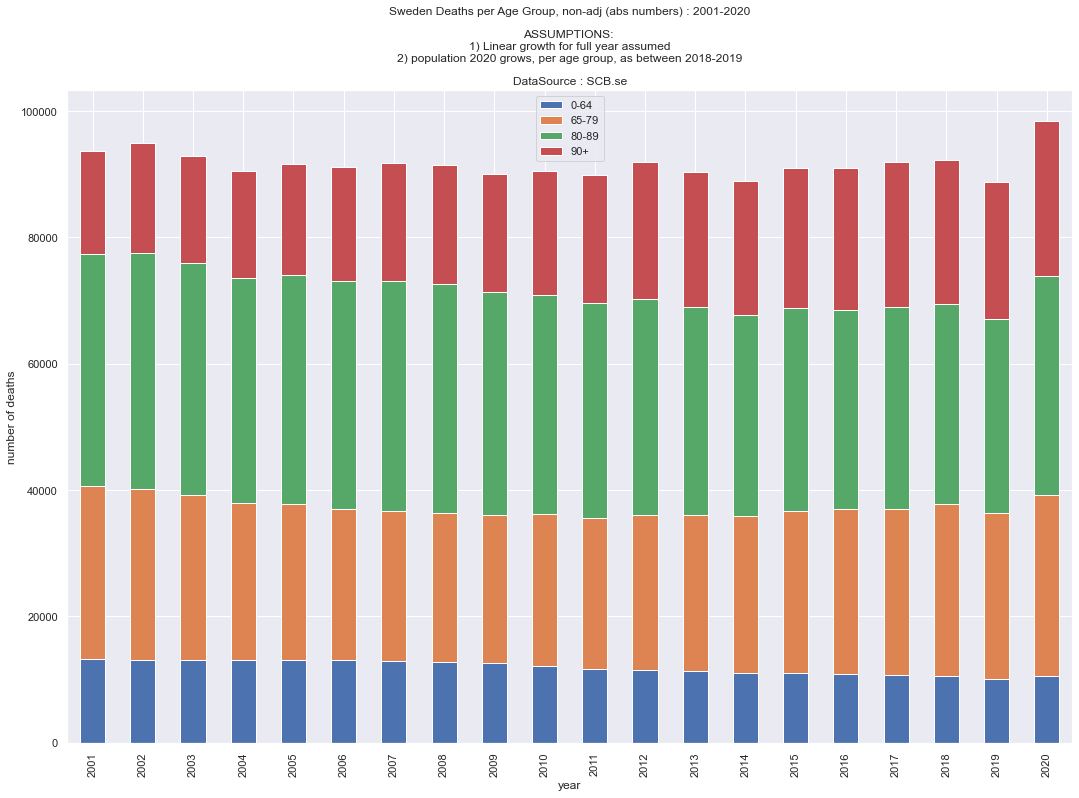

In [244]:
title = 'Sweden Deaths per Age Group, non-adj (abs numbers) : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) Linear growth for full year assumed\n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'
print (computed_death_rate_per_capita)
total_computed_deaths = computed_death_rate_per_capita * strata_abs_pop
total_computed_deaths.plot(kind='bar',
                           stacked=True,figsize=(18,12),title=title)
plt.legend(['0-64','65-79','80-89','90+'])
plt.ylabel('number of deaths')
total_computed_deaths.sum(axis=1)
plt.savefig('age_adj_abs_numbers_age_grp_1.jpg',format='jpg',dpi=600)
total_computed_deaths.sum(axis=1)


In [245]:
tot_abs_deaths = total_computed_deaths.sum(axis=1)
mean_2010_2018 = tot_abs_deaths.loc['2010':'2018'].mean()
tot_abs_deaths

year
2001    93748.0
2002    94991.0
2003    92957.0
2004    90530.0
2005    91704.0
2006    91157.0
2007    91726.0
2008    91441.0
2009    90061.0
2010    90481.0
2011    89940.0
2012    91938.0
2013    90391.0
2014    88974.0
2015    90922.0
2016    90976.0
2017    91969.0
2018    92190.0
2019    88770.0
2020    98376.0
dtype: float64

In [246]:
dead_per_M_strata = (total_computed_deaths / strata_abs_pop * 1e6).astype(int)
dead_per_M_strata

,64,79,89,90+
year,,,,
2001,1801,25567,93294,248865
2002,1772,25322,93976,256579
2003,1763,24509,91143,244826
2004,1754,23268,87596,235916
2005,1754,23028,87990,240340
2006,1736,22163,87175,240527
2007,1713,21520,87731,244759
2008,1692,20711,87318,243847
2009,1646,19972,85422,235741


In [247]:
std_pop = strata_abs_pop.loc[2010]
std_pop

64     7664114.5
79     1218367.0
89      412782.5
90+      82862.0
Name: 2010, dtype: float64

In [248]:
computed_death_rate_per_capita.to_pickle('computed_death_rate_per_capita.pkl')
computed_death_rate_per_capita

,64,79,89,90+
year,,,,
2001,0.001801,0.025567,0.093294,0.248865
2002,0.001773,0.025322,0.093977,0.256579
2003,0.001764,0.024510,0.091143,0.244826
2004,0.001754,0.023268,0.087596,0.235916
2005,0.001754,0.023028,0.087990,0.240341
2006,0.001737,0.022164,0.087176,0.240527
2007,0.001714,0.021520,0.087731,0.244760
2008,0.001693,0.020711,0.087318,0.243848
2009,0.001646,0.019972,0.085423,0.235741


In [249]:
age_adj_deaths = std_pop * computed_death_rate_per_capita
age_adj_deaths

,64,79,89,90+
year,,,,
2001,13806.778610,31150.367781,38510.296159,20621.452633
2002,13587.369221,30851.721585,38792.005928,21260.684970
2003,13519.371214,29862.101739,37622.422558,20286.798628
2004,13445.098896,28349.520774,36158.275829,19548.486565
2005,13442.978043,28057.075475,36320.797370,19915.127127
2006,13309.679372,27003.596895,35984.586242,19930.552481
2007,13134.132754,26219.366138,36213.876240,20281.292798
2008,12973.566543,25233.632808,36043.390798,20205.703447
2009,12616.193375,24333.513190,35261.008764,19533.971700


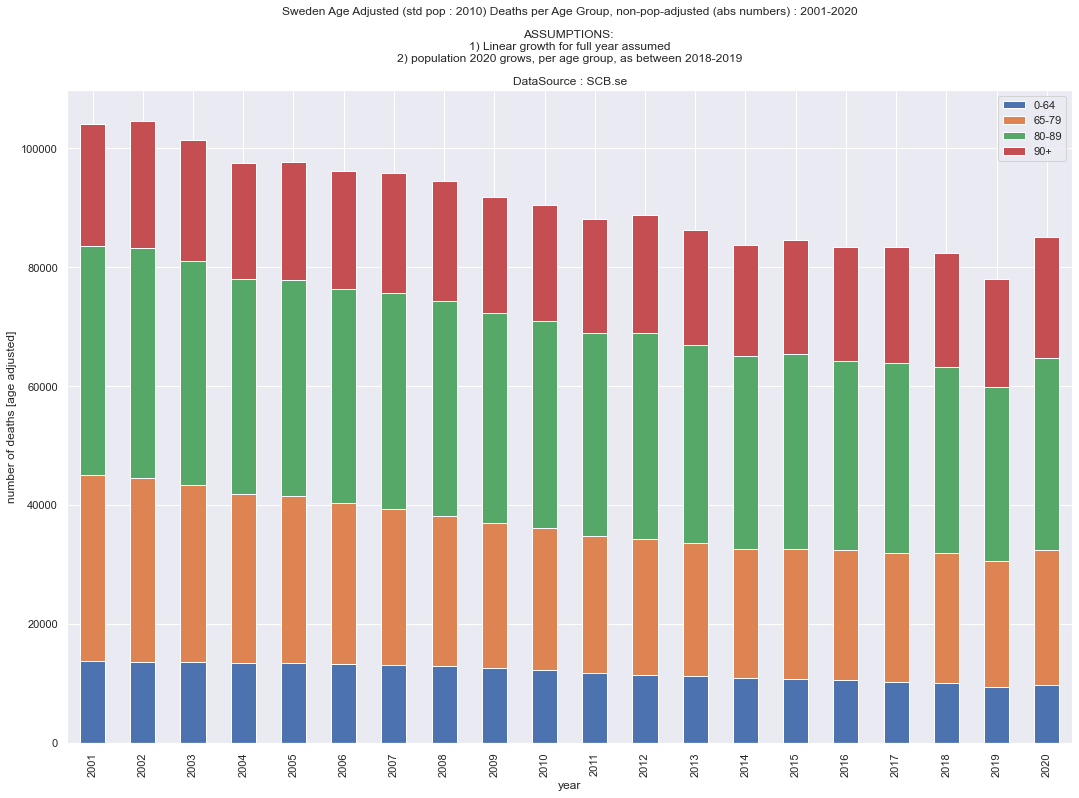

In [250]:
title = 'Sweden Age Adjusted (std pop : 2010) Deaths per Age Group, non-pop-adjusted (abs numbers) : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) Linear growth for full year assumed\n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'
age_adj_deaths.plot(kind='bar',stacked=True,figsize=(18,12),title=title)
plt.legend(['0-64','65-79','80-89','90+'])
plt.ylabel('number of deaths [age adjusted]')
#plt.ylim([0,100000])
plt.savefig('age_adj_no_pop_adjusted_3.jpg',format='jpg',dpi=600)


In [251]:
print (std_pop.sum())
age_adj_deaths_per_M = age_adj_deaths.sum(axis=1) / (std_pop.sum() / 1e6)
age_adj_deaths_per_M

9378126.0


year
2001    11099.114597
2002    11142.074835
2003    10800.739310
2004    10396.680751
2005    10421.695978
2006    10260.942857
2007    10220.450006
2008    10071.979583
2009     9782.837960
2010     9648.089608
2011     9399.144030
2012     9465.043194
2013     9193.719658
2014     8932.068133
2015     9009.971098
2016     8898.181308
2017     8891.178464
2018     8789.125063
2019     8323.563480
2020     9061.337923
dtype: float64

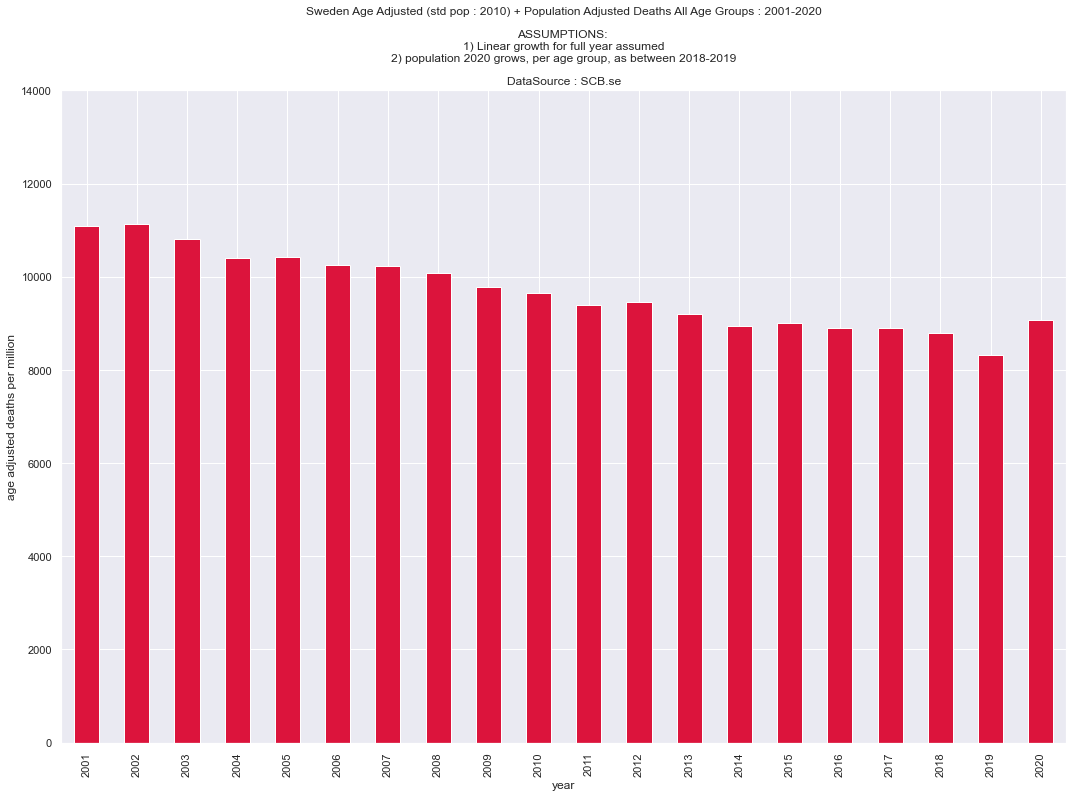

In [252]:
title = 'Sweden Age Adjusted (std pop : 2010) + Population Adjusted Deaths All Age Groups : 2001-2020\n\n' +\
'ASSUMPTIONS: \n1) Linear growth for full year assumed\n' +\
'2) population 2020 grows, per age group, as between 2018-2019\n\n' +\
r'DataSource : SCB.se'

age_adj_deaths_per_M.plot(kind='bar',figsize=(18,12),title=title,color='crimson')
plt.ylabel('age adjusted deaths per million')
plt.ylim(per_M_ylim)
plt.savefig('age_adj_pop_adj_4.jpg',format='jpg')


In [253]:
strata_abs_pop.head()

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0


In [254]:
def create_age_idx(a):
    if a == '64' : return 1
    if a == '79' : return 2
    if a == '89' : return 3
    if a == '90+' : return 4

all_data = strata_abs_pop.unstack().reset_index()
all_data.rename(columns={'level_0' : 'age_grp',0 : 'pop' },inplace=True)

temp = strata_abs_deaths.unstack().reset_index()

temp.rename(columns={'level_0' : 'age_grp', 0 : 'dead'},inplace=True)
all_data = pd.concat([all_data,temp['dead']],axis=1)
all_data['year_idx'] = all_data['year'] - 2000
all_data['age_idx'] = all_data['age_grp'].apply(create_age_idx)
all_data['pop'] = all_data['pop'].astype(int)
all_data.to_pickle('stratified_population_death_age_control.pkl')
all_data.tail(40)

,age_grp,year,pop,dead,year_idx,age_idx
40,89,2001,392306,36600,1,3
41,89,2002,399119,37508,2,3
42,89,2003,403221,36751,3,3
43,89,2004,407459,35692,4,3
44,89,2005,411296,36190,5,3
45,89,2006,413877,36080,6,3
46,89,2007,414345,36351,7,3
47,89,2008,414587,36201,8,3
48,89,2009,414772,35431,9,3
49,89,2010,412782,34780,10,3


In [255]:
#PYMC
import pymc as pm
from pymc.Matplot import plot as pmplot


### condition on year by assigning a unique alpha to each year
### condition on age_grp by assigning a unique beta to each age group

# model: 
# dead ~ Binomial(population,p)
# p = logit(alpha[year_idx] + beta[age_idx])
# alpha[year_idx] ~ Normal(0,10)
# beta[age_idx] ~ Normal(0,10) 


year_idx = all_data['year_idx'] 
age_idx = all_data['age_idx']

alpha = pm.Normal('alpha',0, 1 / 10 ** 2,size=len(year_idx)) # 20 years

beta = pm.Normal('beta',0,1 / 10 ** 2,size=4)


@pm.deterministic
def logit_age(age_idx=age_idx-1,year_idx=year_idx-1,alpha=alpha,beta=beta):
        
    return np.exp(alpha[year_idx] + beta[age_idx]) / (
        1 + np.exp(alpha[year_idx] + beta[age_idx]))


lkh_age = pm.Binomial('lkh_age',n=all_data['pop'],p=logit_age,observed=True,
                      value=all_data['dead'])

model = pm.Model([alpha,beta,logit_age,lkh_age])

_map = pm.MAP(model)
_map.fit()

mcmc = pm.MCMC(model)
sample = mcmc.sample(50000,20000,3)

 [-----------------100%-----------------] 50000 of 50000 complete in 23.9 sec

In [256]:
def logit_pure(x):
    return (np.exp(x)) / (1 + np.exp(x))

def logistic_pure(p):
    return np.log(p / (1 - p))

Plotting beta_64
Plotting beta_79
Plotting beta_89
Plotting beta_90
Plotting alpha_2001
Plotting alpha_2002
Plotting alpha_2012
Plotting alpha_2015
Plotting alpha_2019
Plotting alpha_2020


,alpha_2001,alpha_2002,alpha_2003,alpha_2004,alpha_2005,alpha_2006,alpha_2007,alpha_2008,alpha_2009,alpha_2010,...,alpha_2015,alpha_2016,alpha_2017,alpha_2018,alpha_2019,alpha_2020,beta_64,beta_79,beta_89,beta_90
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,11.930348,11.933757,11.899127,11.856968,11.859552,11.842265,11.838588,11.822642,11.790642,11.774860,...,11.698924,11.686238,11.684986,11.673522,11.615211,11.707829,-18.249071,-15.658250,-14.174399,-12.936438
std,0.011470,0.011338,0.011384,0.011540,0.011476,0.011333,0.011329,0.011354,0.011589,0.011097,...,0.011373,0.011295,0.011104,0.011117,0.011008,0.011401,0.011063,0.010957,0.010901,0.010964
min,11.903953,11.902768,11.873889,11.828007,11.833410,11.814085,11.813297,11.794544,11.764891,11.748323,...,11.668809,11.660106,11.656950,11.647219,11.589226,11.679247,-18.274038,-15.682418,-14.198499,-12.962343
25%,11.920639,11.924339,11.889535,11.846907,11.849652,11.832333,11.828853,11.812878,11.780380,11.764845,...,11.689321,11.676547,11.675598,11.663831,11.605712,11.698166,-18.258049,-15.667203,-14.183385,-12.945325
50%,11.930651,11.934054,11.898936,11.856962,11.860083,11.842858,11.839247,11.823256,11.791192,11.775414,...,11.699496,11.686260,11.685216,11.673834,11.615477,11.708168,-18.249671,-15.658868,-14.175090,-12.937119
75%,11.939467,11.942631,11.908326,11.866015,11.868550,11.850916,11.847550,11.831508,11.799982,11.783470,...,11.708162,11.695386,11.693671,11.681886,11.623892,11.716975,-18.239289,-15.648328,-14.164437,-12.926473
max,11.960026,11.962652,11.928652,11.886418,11.888238,11.868968,11.865906,11.852654,11.820063,11.802421,...,11.727411,11.712221,11.712190,11.701691,11.643526,11.734933,-18.224398,-15.635021,-14.152093,-12.913666


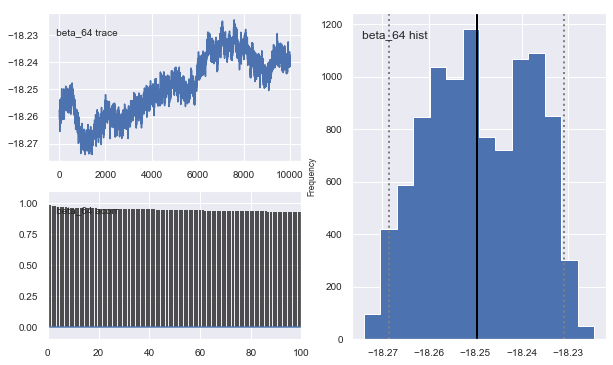

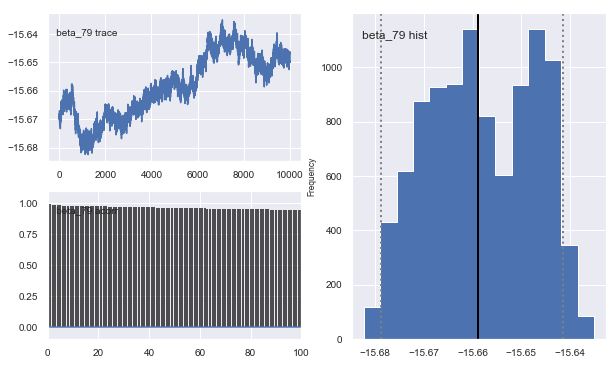

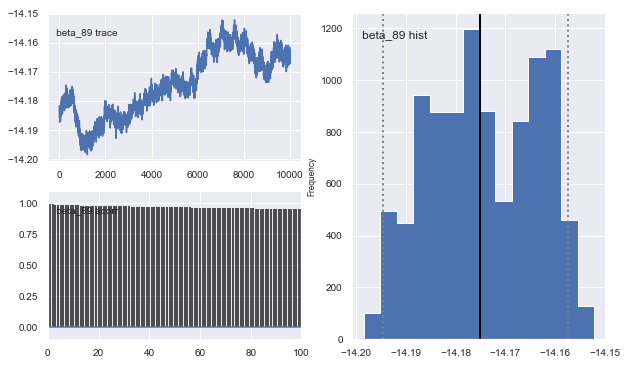

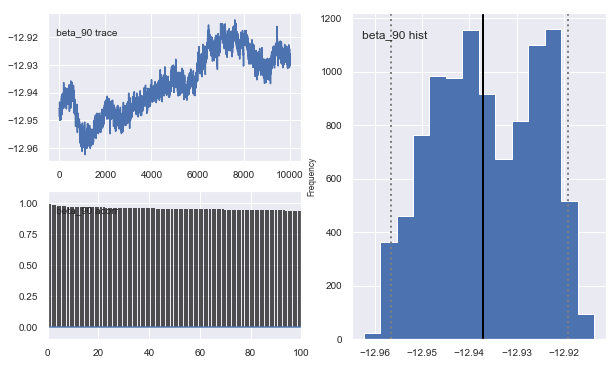

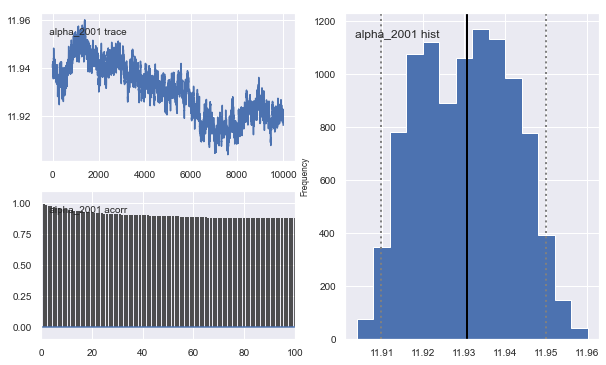

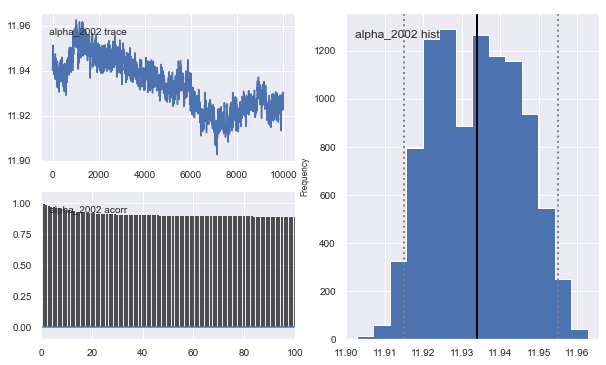

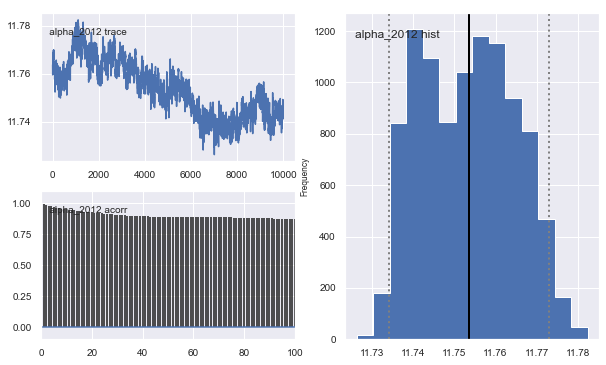

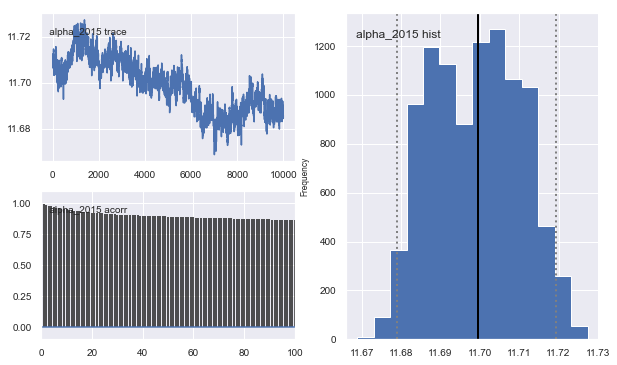

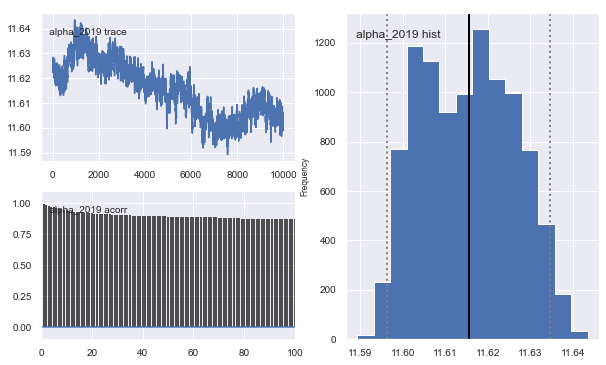

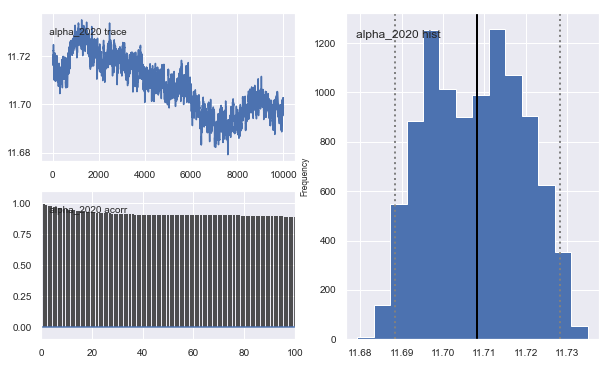

In [257]:
#

alpha_2001 = mcmc.trace('alpha')[:,0]
alpha_2002 = mcmc.trace('alpha')[:,1]
alpha_2003 = mcmc.trace('alpha')[:,2]
alpha_2004 = mcmc.trace('alpha')[:,3]
alpha_2005 = mcmc.trace('alpha')[:,4]
alpha_2006 = mcmc.trace('alpha')[:,5]
alpha_2007 = mcmc.trace('alpha')[:,6]
alpha_2008 = mcmc.trace('alpha')[:,7]
alpha_2009 = mcmc.trace('alpha')[:,8]
alpha_2010 = mcmc.trace('alpha')[:,9]
alpha_2011 = mcmc.trace('alpha')[:,10]
alpha_2012 = mcmc.trace('alpha')[:,11]
alpha_2013 = mcmc.trace('alpha')[:,12]
alpha_2014 = mcmc.trace('alpha')[:,13]
alpha_2015 = mcmc.trace('alpha')[:,14]
alpha_2016 = mcmc.trace('alpha')[:,15]
alpha_2017 = mcmc.trace('alpha')[:,16]
alpha_2018 = mcmc.trace('alpha')[:,17]
alpha_2019 = mcmc.trace('alpha')[:,18]
alpha_2020 = mcmc.trace('alpha')[:,19]


beta_64 = mcmc.trace('beta')[:,0]
beta_79 = mcmc.trace('beta')[:,1]
beta_89 = mcmc.trace('beta')[:,2]
beta_90 = mcmc.trace('beta')[:,3]

pmplot(beta_64,'beta_64')
pmplot(beta_79,'beta_79')
pmplot(beta_89,'beta_89')
pmplot(beta_90,'beta_90')

pmplot(alpha_2001,'alpha_2001')
pmplot(alpha_2002,'alpha_2002')
pmplot(alpha_2012,'alpha_2012')
pmplot(alpha_2015,'alpha_2015')
pmplot(alpha_2019,'alpha_2019')
pmplot(alpha_2020,'alpha_2020')




result = pd.DataFrame({
                       'alpha_2001': alpha_2001,
                       'alpha_2002' : alpha_2002,
                       'alpha_2003' : alpha_2003,
                       'alpha_2004' : alpha_2004,
                       'alpha_2005' : alpha_2005,
                       'alpha_2006' : alpha_2006,
                       'alpha_2007' : alpha_2007,
                       'alpha_2008' : alpha_2008,
                       'alpha_2009' : alpha_2009,
                       'alpha_2010' : alpha_2010,
                       'alpha_2011' : alpha_2011,
                       'alpha_2012' : alpha_2012,
                       'alpha_2013' : alpha_2013,
                       'alpha_2014' : alpha_2014,
                       'alpha_2015' : alpha_2015,
                       'alpha_2016' : alpha_2016,
                       'alpha_2017' : alpha_2017,
                       'alpha_2018' : alpha_2018,
                       'alpha_2019' : alpha_2019,
                        'alpha_2020' : alpha_2020,
                        'beta_64' : beta_64,
                        'beta_79' : beta_79,
                        'beta_89' : beta_89,
                        'beta_90' : beta_90})
                      

result.describe()


In [258]:
result_p = pd.DataFrame()

result_p['2001_64'] = logit_pure(result['alpha_2001'] + result['beta_64']) 
result_p['2001_79'] = logit_pure(result['alpha_2001'] + result['beta_79']) 
result_p['2001_89'] = logit_pure(result['alpha_2001'] + result['beta_89']) 
result_p['2001_90'] = logit_pure(result['alpha_2001'] + result['beta_90']) 

result_p['2002_64'] = logit_pure(result['alpha_2002'] + result['beta_64']) 
result_p['2002_79'] = logit_pure(result['alpha_2002'] + result['beta_79']) 
result_p['2002_89'] = logit_pure(result['alpha_2002'] + result['beta_89']) 
result_p['2002_90'] = logit_pure(result['alpha_2002'] + result['beta_90']) 

result_p['2003_64'] = logit_pure(result['alpha_2003'] + result['beta_64']) 
result_p['2003_79'] = logit_pure(result['alpha_2003'] + result['beta_79']) 
result_p['2003_89'] = logit_pure(result['alpha_2003'] + result['beta_89']) 
result_p['2003_90'] = logit_pure(result['alpha_2003'] + result['beta_90']) 

result_p['2004_64'] = logit_pure(result['alpha_2004'] + result['beta_64']) 
result_p['2004_79'] = logit_pure(result['alpha_2004'] + result['beta_79']) 
result_p['2004_89'] = logit_pure(result['alpha_2004'] + result['beta_89']) 
result_p['2004_90'] = logit_pure(result['alpha_2004'] + result['beta_90']) 

result_p['2005_64'] = logit_pure(result['alpha_2005'] + result['beta_64']) 
result_p['2005_79'] = logit_pure(result['alpha_2005'] + result['beta_79']) 
result_p['2005_89'] = logit_pure(result['alpha_2005'] + result['beta_89']) 
result_p['2005_90'] = logit_pure(result['alpha_2005'] + result['beta_90']) 

result_p['2006_64'] = logit_pure(result['alpha_2006'] + result['beta_64']) 
result_p['2006_79'] = logit_pure(result['alpha_2006'] + result['beta_79']) 
result_p['2006_89'] = logit_pure(result['alpha_2006'] + result['beta_89']) 
result_p['2006_90'] = logit_pure(result['alpha_2006'] + result['beta_90']) 

result_p['2007_64'] = logit_pure(result['alpha_2007'] + result['beta_64']) 
result_p['2007_79'] = logit_pure(result['alpha_2007'] + result['beta_79']) 
result_p['2007_89'] = logit_pure(result['alpha_2007'] + result['beta_89']) 
result_p['2007_90'] = logit_pure(result['alpha_2007'] + result['beta_90']) 

result_p['2008_64'] = logit_pure(result['alpha_2008'] + result['beta_64']) 
result_p['2008_79'] = logit_pure(result['alpha_2008'] + result['beta_79']) 
result_p['2008_89'] = logit_pure(result['alpha_2008'] + result['beta_89']) 
result_p['2008_90'] = logit_pure(result['alpha_2008'] + result['beta_90']) 

result_p['2009_64'] = logit_pure(result['alpha_2009'] + result['beta_64']) 
result_p['2009_79'] = logit_pure(result['alpha_2009'] + result['beta_79']) 
result_p['2009_89'] = logit_pure(result['alpha_2009'] + result['beta_89']) 
result_p['2009_90'] = logit_pure(result['alpha_2009'] + result['beta_90']) 

result_p['2010_64'] = logit_pure(result['alpha_2010'] + result['beta_64']) 
result_p['2010_79'] = logit_pure(result['alpha_2010'] + result['beta_79']) 
result_p['2010_89'] = logit_pure(result['alpha_2010'] + result['beta_89']) 
result_p['2010_90'] = logit_pure(result['alpha_2010'] + result['beta_90']) 

result_p['2011_64'] = logit_pure(result['alpha_2011'] + result['beta_64']) 
result_p['2011_79'] = logit_pure(result['alpha_2011'] + result['beta_79']) 
result_p['2011_89'] = logit_pure(result['alpha_2011'] + result['beta_89']) 
result_p['2011_90'] = logit_pure(result['alpha_2011'] + result['beta_90']) 

result_p['2012_64'] = logit_pure(result['alpha_2012'] + result['beta_64']) 
result_p['2012_79'] = logit_pure(result['alpha_2012'] + result['beta_79']) 
result_p['2012_89'] = logit_pure(result['alpha_2012'] + result['beta_89']) 
result_p['2012_90'] = logit_pure(result['alpha_2012'] + result['beta_90']) 

result_p['2013_64'] = logit_pure(result['alpha_2013'] + result['beta_64']) 
result_p['2013_79'] = logit_pure(result['alpha_2013'] + result['beta_79']) 
result_p['2013_89'] = logit_pure(result['alpha_2013'] + result['beta_89']) 
result_p['2013_90'] = logit_pure(result['alpha_2013'] + result['beta_90']) 

result_p['2014_64'] = logit_pure(result['alpha_2014'] + result['beta_64']) 
result_p['2014_79'] = logit_pure(result['alpha_2014'] + result['beta_79']) 
result_p['2014_89'] = logit_pure(result['alpha_2014'] + result['beta_89']) 
result_p['2014_90'] = logit_pure(result['alpha_2014'] + result['beta_90']) 

result_p['2015_64'] = logit_pure(result['alpha_2015'] + result['beta_64']) 
result_p['2015_79'] = logit_pure(result['alpha_2015'] + result['beta_79']) 
result_p['2015_89'] = logit_pure(result['alpha_2015'] + result['beta_89']) 
result_p['2015_90'] = logit_pure(result['alpha_2015'] + result['beta_90']) 

result_p['2016_64'] = logit_pure(result['alpha_2016'] + result['beta_64']) 
result_p['2016_79'] = logit_pure(result['alpha_2016'] + result['beta_79']) 
result_p['2016_89'] = logit_pure(result['alpha_2016'] + result['beta_89']) 
result_p['2016_90'] = logit_pure(result['alpha_2016'] + result['beta_90']) 

result_p['2017_64'] = logit_pure(result['alpha_2017'] + result['beta_64']) 
result_p['2017_79'] = logit_pure(result['alpha_2017'] + result['beta_79']) 
result_p['2017_89'] = logit_pure(result['alpha_2017'] + result['beta_89']) 
result_p['2017_90'] = logit_pure(result['alpha_2017'] + result['beta_90']) 

result_p['2018_64'] = logit_pure(result['alpha_2018'] + result['beta_64']) 
result_p['2018_79'] = logit_pure(result['alpha_2018'] + result['beta_79']) 
result_p['2018_89'] = logit_pure(result['alpha_2018'] + result['beta_89']) 
result_p['2018_90'] = logit_pure(result['alpha_2018'] + result['beta_90']) 

result_p['2019_64'] = logit_pure(result['alpha_2019'] + result['beta_64']) 
result_p['2019_79'] = logit_pure(result['alpha_2019'] + result['beta_79']) 
result_p['2019_89'] = logit_pure(result['alpha_2019'] + result['beta_89']) 
result_p['2019_90'] = logit_pure(result['alpha_2019'] + result['beta_90']) 

result_p['2020_64'] = logit_pure(result['alpha_2020'] + result['beta_64']) 
result_p['2020_79'] = logit_pure(result['alpha_2020'] + result['beta_79']) 
result_p['2020_89'] = logit_pure(result['alpha_2020'] + result['beta_89']) 
result_p['2020_90'] = logit_pure(result['alpha_2020'] + result['beta_90']) 

result_p.describe()


,2001_64,2001_79,2001_89,2001_90,2002_64,2002_79,2002_89,2002_90,2003_64,2003_79,...,2018_89,2018_90,2019_64,2019_79,2019_89,2019_90,2020_64,2020_79,2020_89,2020_90
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.001799,0.023479,0.095864,0.267746,0.001805,0.023557,0.096160,0.268415,0.001744,0.022774,...,0.075797,0.220473,0.001313,0.017242,0.071812,0.210615,0.001441,0.018883,0.078236,0.226426
std,0.000007,0.000081,0.000304,0.000738,0.000007,0.000083,0.000305,0.000738,0.000007,0.000081,...,0.000251,0.000644,0.000005,0.000061,0.000236,0.000628,0.000005,0.000064,0.000244,0.000614
min,0.001769,0.023195,0.094837,0.265284,0.001780,0.023244,0.094938,0.265479,0.001719,0.022463,...,0.074672,0.218057,0.001294,0.017020,0.070877,0.208373,0.001419,0.018639,0.077378,0.224113
25%,0.001794,0.023424,0.095658,0.267249,0.001801,0.023499,0.095959,0.267911,0.001739,0.022718,...,0.075634,0.220050,0.001310,0.017201,0.071657,0.210203,0.001437,0.018842,0.078076,0.226023
50%,0.001799,0.023477,0.095863,0.267727,0.001805,0.023558,0.096164,0.268422,0.001744,0.022774,...,0.075803,0.220487,0.001313,0.017242,0.071815,0.210615,0.001441,0.018884,0.078234,0.226429
75%,0.001803,0.023534,0.096066,0.268247,0.001810,0.023615,0.096367,0.268919,0.001749,0.022830,...,0.075968,0.220914,0.001317,0.017282,0.071973,0.211030,0.001444,0.018925,0.078398,0.226839
max,0.001824,0.023810,0.096907,0.270176,0.001828,0.023812,0.097130,0.271040,0.001767,0.023054,...,0.076717,0.222524,0.001331,0.017449,0.072544,0.212737,0.001462,0.019117,0.079166,0.229188


In [259]:
p_means = result_p.describe().loc['mean']
p_means = p_means.reset_index()
p_means[['year','age_grp']] = p_means['index'].str.split('_',1,expand=True)
p_means = pd.pivot(p_means,index='age_grp',columns='year',values='mean')
p_means = p_means.T
p_means.rename(columns={'90' : '90+'},inplace=True)

In [260]:
p_means.index = range(2001,2021)

In [261]:
strata_abs_pop.to_pickle('strata_abs_pop.pkl')

In [262]:
pymc_abs_deaths_cond_year_age = strata_abs_pop * p_means

pymc_abs_sum = pymc_abs_deaths_cond_year_age.sum(axis=1)
pymc_abs_deaths_cond_year_age

,64,79,89,90+
year,,,,
2001,13248.817084,25194.902508,37608.180372,17692.676414
2002,13343.695942,25113.355439,38379.390581,18184.859643
2003,12940.312085,24249.139335,37577.073161,18188.790143
2004,12448.853870,23354.415392,36545.043804,18178.039866
2005,12521.208927,23554.816197,36976.019181,18664.398142
2006,12368.564516,23366.474641,36626.824893,18770.287829
2007,12398.849738,23703.619213,36545.521245,19076.566457
2008,12267.203569,23978.829950,36038.689289,19142.886825
2009,11940.459162,24047.488776,35015.143497,19053.741066


In [263]:
computed_abs_sum = total_computed_deaths.sum(axis=1)
total_computed_deaths

,64,79,89,90+
year,,,,
2001,13267.0,27436.0,36600.0,16445.0
2002,13105.0,26995.0,37508.0,17383.0
2003,13090.0,26098.0,36751.0,17018.0
2004,13062.0,24866.0,35692.0,16910.0
2005,13102.0,24758.0,36190.0,17654.0
2006,13037.0,24041.0,36080.0,17999.0
2007,12944.0,23765.0,36351.0,18666.0
2008,12853.0,23501.0,36201.0,18886.0
2009,12561.0,23451.0,35431.0,18618.0


In [264]:
combined_abs_sums = pd.concat([pymc_abs_sum,computed_abs_sum],axis=1)
combined_abs_sums.columns=['pymc_abs_dead','analytic_abs_dead']

combined_abs_sums

,pymc_abs_dead,analytic_abs_dead
year,,
2001,93744.576378,93748.0
2002,95021.301604,94991.0
2003,92955.314724,92957.0
2004,90526.352931,90530.0
2005,91716.442446,91704.0
2006,91132.151879,91157.0
2007,91724.556653,91726.0
2008,91427.609634,91441.0
2009,90056.832500,90061.0


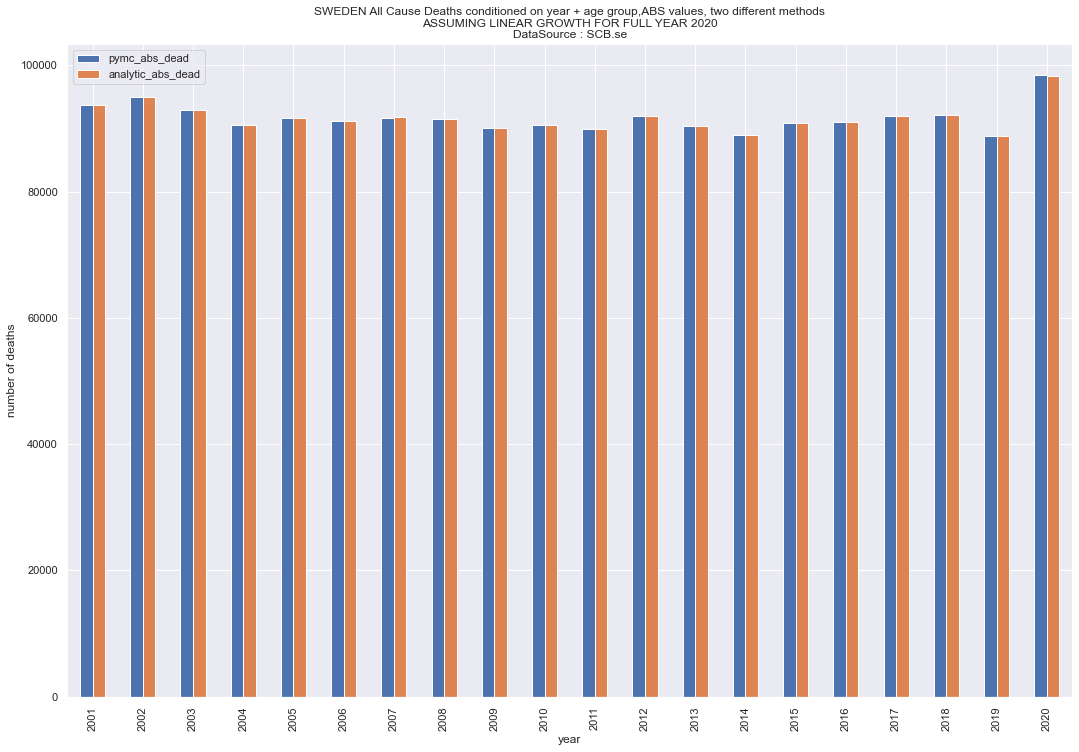

In [265]:
title = 'SWEDEN All Cause Deaths conditioned on year + age group,ABS values, two different methods\n'\
'ASSUMING LINEAR GROWTH FOR FULL YEAR 2020\nDataSource : SCB.se'

combined_abs_sums.plot(kind='bar',
                       figsize=(18,12),
                       title=title)
plt.ylabel('number of deaths')
plt.savefig('pymc_cond_year_age_abs.jpg',format='jpg')

In [266]:
yearly_pop = strata_abs_pop.sum(axis=1)

pop_adj_deaths = combined_abs_sums.div(yearly_pop / 1e6,axis=0)
pop_adj_deaths.columns = ['pymc_dead_per_M','analytic_dead_per_M']
pop_adj_deaths

,pymc_dead_per_M,analytic_dead_per_M
year,,
2001,10537.881957,10538.266809
2002,10646.694539,10643.299386
2003,10376.528075,10376.716201
2004,10065.718674,10066.124195
2005,10157.341062,10155.963095
2006,10036.022985,10038.759410
2007,10026.632510,10026.790286
2008,9916.617068,9918.069442
2009,9685.077385,9685.525575


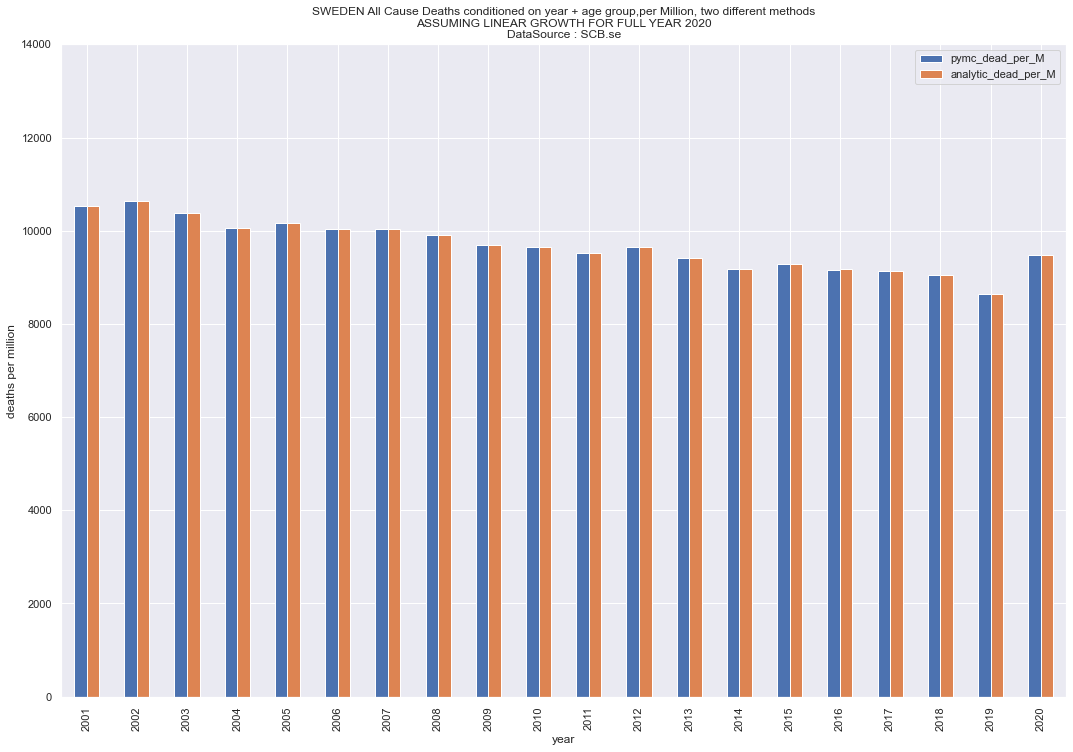

In [267]:
title = 'SWEDEN All Cause Deaths conditioned on year + age group,per Million, two different methods\n'\
'ASSUMING LINEAR GROWTH FOR FULL YEAR 2020\n'+\
'DataSource : SCB.se'
pop_adj_deaths.plot(kind='bar',figsize=(18,12),
                    title=title)

plt.ylabel('deaths per million')
plt.ylim(per_M_ylim)
plt.savefig('pymc_cond_year_age_per_M.jpg',format='jpg')

In [268]:
pymc_deaths_per_M_per_age_grp = pymc_abs_deaths_cond_year_age.T / (yearly_pop / 1e6)
pymc_deaths_per_M_per_age_grp = pymc_deaths_per_M_per_age_grp.T

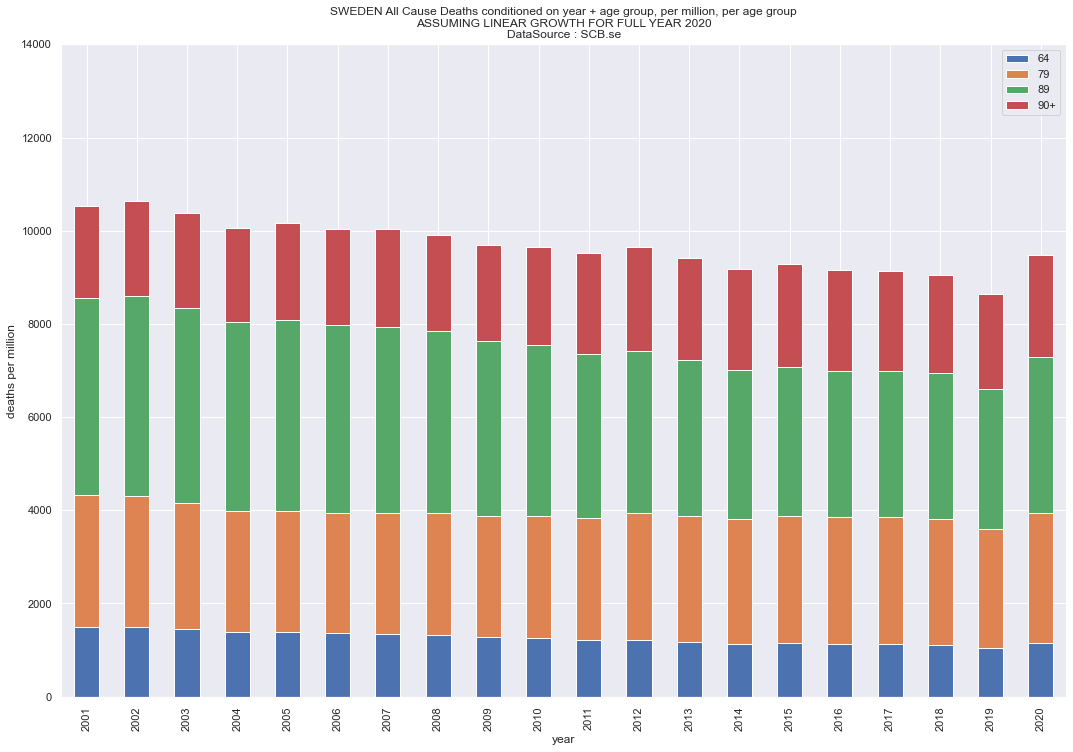

In [269]:
title = 'SWEDEN All Cause Deaths conditioned on year + age group, per million, per age group\n'\
'ASSUMING LINEAR GROWTH FOR FULL YEAR 2020\n'+\
'DataSource : SCB.se'
pymc_deaths_per_M_per_age_grp.plot(kind='bar',title=title,
                                   stacked=True,figsize=(18,12))
plt.ylabel('deaths per million')
plt.ylim(per_M_ylim)
plt.savefig('pymc_cond_age_year_per_M_stratified.jpg',format='jpg')

In [270]:
### include median age of death as proxy for health

url4 = 'http://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101I/LivslangdEttariga'
data4 = {
  "query": [
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "BE0101A$"
        ]
      }
    }
  ],
  "response": {
    "format": "json"
  }
}

In [271]:
r4 = requests.post(url4,json=data4)
r4.status_code

200

In [272]:
json4 = r4.json()
json4['data'][0]

{'key': ['1', '0', '1960'], 'values': ['71.24']}

In [273]:
data_list4 = []

for rec in json4['data']:
    data_list4.append((rec['key'][0],rec['key'][2],rec['values'][0]))
    
median_age_of_death = pd.DataFrame(data_list4,columns=['gender','year','median'])
median_age_of_death.set_index('year',inplace=True)
median_age_of_death['median'] = median_age_of_death['median'].astype(float)

median_age_of_death

,gender,median
year,,
1960,1,71.24
1961,1,71.56
1962,1,71.32
1963,1,71.56
1964,1,71.66
...,...,...
2015,2,84.01
2016,2,84.09
2017,2,84.10


Text(0, 0.5, 'median age death')

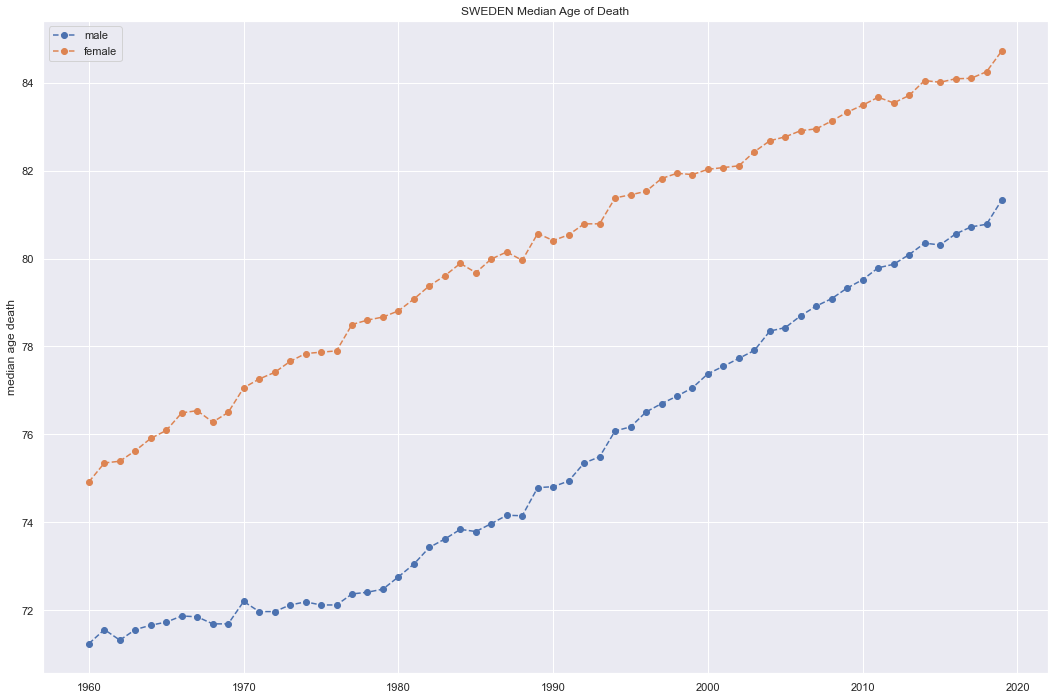

In [274]:
gender_groups = median_age_of_death.groupby('gender')

male = gender_groups.get_group('1')
male.index = range(1960,2020)

ax = male.plot(style='o--',figsize=(18,12))

female = gender_groups.get_group('2')
female.index = range(1960,2020)
female.plot(ax=ax,style='o--')

ax.legend(['male','female'])
plt.title('SWEDEN Median Age of Death')
plt.ylabel('median age death')

In [275]:
all_data

,age_grp,year,pop,dead,year_idx,age_idx
0,64,2001,7364484,13267,1,1
1,64,2002,7392028,13105,2,1
2,64,2003,7420704,13090,3,1
3,64,2004,7445736,13062,4,1
4,64,2005,7469716,13102,5,1
...,...,...,...,...,...,...
75,90+,2016,96741,22499,16,4
76,90+,2017,97251,22907,17,4
77,90+,2018,97843,22667,18,4
78,90+,2019,98965,21754,19,4


In [276]:
all_data_no_2020 = all_data.loc[all_data['year'] != 2020]

# use male median death as health proxy
all_data_no_2020 = all_data_no_2020.join(male,on='year')
all_data_no_2020['std_median'] = all_data_no_2020['median'].apply(
    lambda x : (x - all_data_no_2020['median'].mean()) / all_data_no_2020['median'].std())

all_data_no_2020['mortality'] = all_data_no_2020['dead'] / all_data_no_2020['pop']

all_data_no_2020['health_idx'] = all_data_no_2020['median'].astype(int) - 76 # index 1..5
all_data_no_2020['std_year'] = all_data_no_2020['year_idx'].apply(
    lambda x : (x - all_data_no_2020['year_idx'].mean()) / all_data_no_2020['year_idx'].std())

all_data_no_2020

,age_grp,year,pop,dead,year_idx,age_idx,gender,median,std_median,mortality,health_idx,std_year
0,64,2001,7364484,13267,1,1,1,77.55,-1.719877,0.001801,1,-1.632322
1,64,2002,7392028,13105,2,1,1,77.73,-1.555988,0.001773,1,-1.450953
2,64,2003,7420704,13090,3,1,1,77.91,-1.392099,0.001764,1,-1.269583
3,64,2004,7445736,13062,4,1,1,78.35,-0.991481,0.001754,2,-1.088214
4,64,2005,7469716,13102,5,1,1,78.43,-0.918642,0.001754,2,-0.906845
...,...,...,...,...,...,...,...,...,...,...,...,...
74,90+,2015,95679,22167,15,4,1,80.31,0.793089,0.231681,4,0.906845
75,90+,2016,96741,22499,16,4,1,80.56,1.020713,0.232569,4,1.088214
76,90+,2017,97251,22907,17,4,1,80.72,1.166392,0.235545,4,1.269583
77,90+,2018,97843,22667,18,4,1,80.78,1.221022,0.231667,4,1.450953


In [277]:
all_data_no_2020.loc[all_data_no_2020['year'].isin([2008,2009,2010,2011])]

,age_grp,year,pop,dead,year_idx,age_idx,gender,median,std_median,mortality,health_idx,std_year
7,64,2008,7592890,12853,8,1,1,79.09,-0.317715,0.001693,3,-0.362738
8,64,2009,7630585,12561,9,1,1,79.33,-0.099196,0.001646,3,-0.181369
9,64,2010,7664114,12159,10,1,1,79.52,0.073798,0.001586,3,0.000000
10,64,2011,7688255,11693,11,1,1,79.79,0.319632,0.001521,3,0.181369
27,79,2008,1134709,23501,8,2,1,79.09,-0.317715,0.020711,3,-0.362738
28,79,2009,1174180,23451,9,2,1,79.33,-0.099196,0.019972,3,-0.181369
29,79,2010,1218367,24014,10,2,1,79.52,0.073798,0.019710,3,0.000000
30,79,2011,1263396,23928,11,2,1,79.79,0.319632,0.018939,3,0.181369
47,89,2008,414587,36201,8,3,1,79.09,-0.317715,0.087318,3,-0.362738
48,89,2009,414772,35431,9,3,1,79.33,-0.099196,0.085423,3,-0.181369


In [278]:
all_data_no_2020.corr()

,year,pop,dead,year_idx,age_idx,median,std_median,mortality,health_idx,std_year
year,1.000000,0.034043,-0.025218,1.000000,0.000000e+00,0.994953,9.949532e-01,-0.041290,0.965000,1.000000e+00
pop,0.034043,1.000000,-0.734766,0.034043,-8.502170e-01,0.033494,3.349434e-02,-0.621912,0.032221,3.404299e-02
dead,-0.025218,-0.734766,1.000000,-0.025218,4.368551e-01,-0.028295,-2.829547e-02,0.088926,-0.031166,-2.521778e-02
year_idx,1.000000,0.034043,-0.025218,1.000000,0.000000e+00,0.994953,9.949532e-01,-0.041290,0.965000,1.000000e+00
age_idx,0.000000,-0.850217,0.436855,0.000000,1.000000e+00,0.000000,3.156669e-17,0.928628,0.000000,-5.261115e-18
median,0.994953,0.033494,-0.028295,0.994953,0.000000e+00,1.000000,1.000000e+00,-0.042122,0.976663,9.949532e-01
std_median,0.994953,0.033494,-0.028295,0.994953,3.156669e-17,1.000000,1.000000e+00,-0.042122,0.976663,9.949532e-01
mortality,-0.041290,-0.621912,0.088926,-0.041290,9.286277e-01,-0.042122,-4.212158e-02,1.000000,-0.042210,-4.128990e-02
health_idx,0.965000,0.032221,-0.031166,0.965000,0.000000e+00,0.976663,9.766633e-01,-0.042210,1.000000,9.649997e-01
std_year,1.000000,0.034043,-0.025218,1.000000,-5.261115e-18,0.994953,9.949532e-01,-0.041290,0.965000,1.000000e+00


In [279]:

alpha = pm.Normal('alpha', 0, 1 / 1 ** 2,size=19)
beta = pm.Normal('beta',0, 1 /1 ** 2,size=4)

age_idx = all_data_no_2020['age_idx']
year_idx = all_data_no_2020['year_idx']

@pm.deterministic
def lgit(alpha=alpha,beta=beta,age_idx=age_idx-1,year_idx=year_idx-1):
    return np.exp(alpha[year_idx]   + beta[age_idx]) / (
        1 + np.exp(alpha[year_idx]  + beta[age_idx] ))

likelihood = pm.Binomial('likelihood',n=all_data_no_2020['pop'],p=lgit,observed=True,value=all_data_no_2020['dead'])

model = pm.Model([alpha,beta,lgit,likelihood])

mcmc = pm.MCMC(model)
sample = mcmc.sample(100000,40000,3)

 [-----------------100%-----------------] 100000 of 100000 complete in 45.4 sec

Plotting alpha_post_0
Plotting alpha_post_1
Plotting alpha_post_2
Plotting alpha_post_3
Plotting alpha_post_4
Plotting alpha_post_5
Plotting alpha_post_6
Plotting alpha_post_7
Plotting alpha_post_8
Plotting alpha_post_9
Plotting alpha_post_10
Plotting alpha_post_11
Plotting alpha_post_12
Plotting alpha_post_13
Plotting alpha_post_14
Plotting alpha_post_15
Plotting alpha_post_16
Plotting alpha_post_17
Plotting alpha_post_18
Plotting beta_post_0
Plotting beta_post_1
Plotting beta_post_2
Plotting beta_post_3


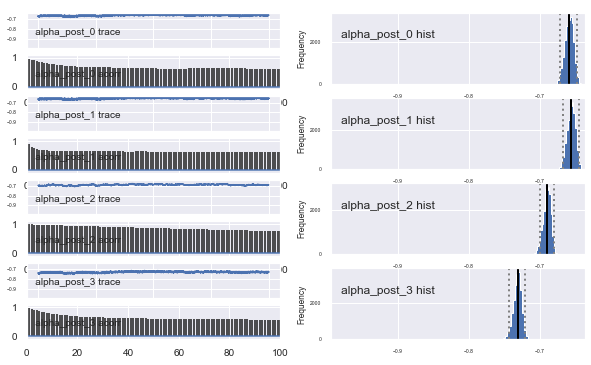

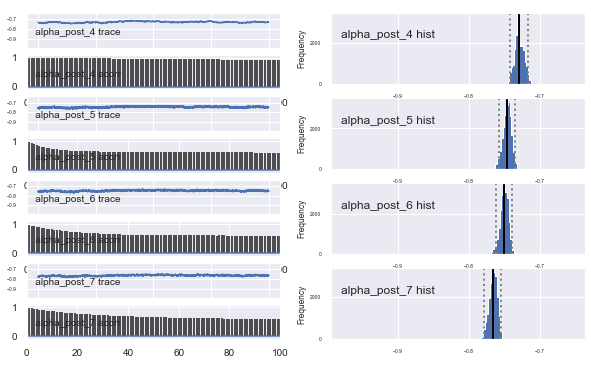

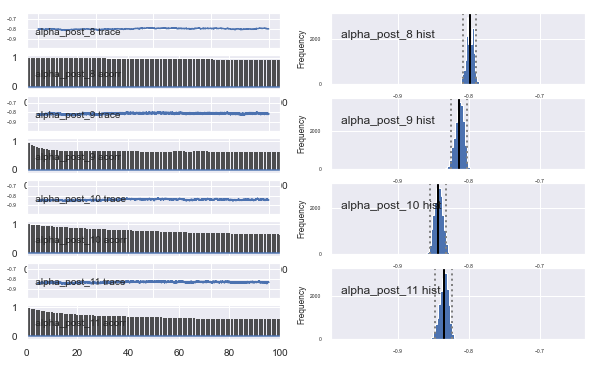

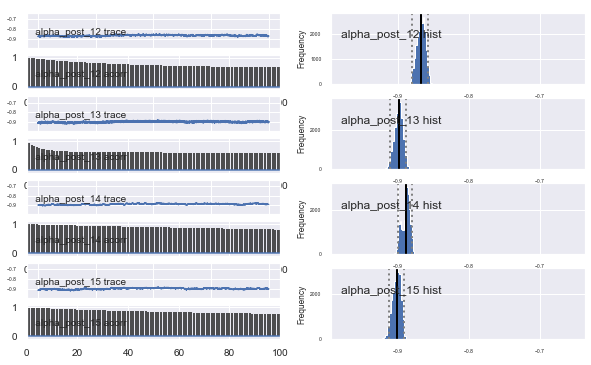

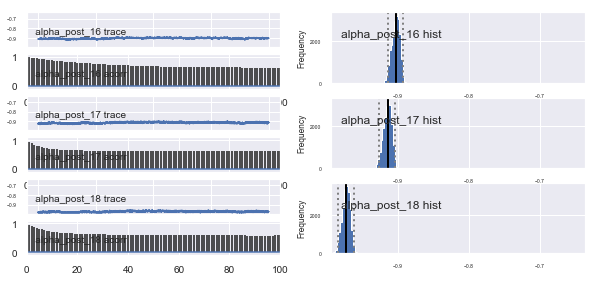

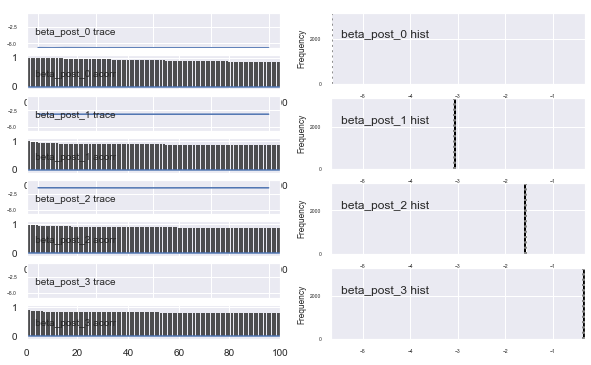

In [280]:
alpha_post = mcmc.trace('alpha')[:]
beta_post = mcmc.trace('beta')[:]

pmplot(alpha_post,'alpha_post')
pmplot(beta_post,'beta_post')

result = pd.DataFrame(alpha_post)

In [281]:
result.columns = range(2001,2020)
result = pd.concat([result,pd.DataFrame(beta_post)],axis=1)


In [282]:
result.describe()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,...,2014,2015,2016,2017,2018,2019,0,1,2,3
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-0.658410,-0.655414,-0.689767,-0.731420,-0.728916,-0.746108,-0.750107,-0.765785,-0.798416,-0.813571,...,-0.899086,-0.889153,-0.902007,-0.903288,-0.914771,-0.973093,-5.654498,-3.068836,-1.585932,-0.354050
std,0.006139,0.005891,0.005401,0.005822,0.006479,0.005963,0.005960,0.005907,0.004967,0.005996,...,0.005897,0.005735,0.006073,0.005778,0.005959,0.005835,0.005103,0.005010,0.004965,0.005167
min,-0.681055,-0.675649,-0.707374,-0.754110,-0.744726,-0.767141,-0.771695,-0.787560,-0.810790,-0.835953,...,-0.921113,-0.904783,-0.922604,-0.924444,-0.933844,-0.994301,-5.666300,-3.080858,-1.597540,-0.367519
25%,-0.662536,-0.659407,-0.693086,-0.735190,-0.733321,-0.750067,-0.753916,-0.769657,-0.802240,-0.817682,...,-0.902996,-0.893627,-0.906322,-0.907387,-0.918803,-0.976847,-5.658695,-3.072786,-1.589898,-0.358061
50%,-0.657986,-0.654988,-0.689301,-0.730893,-0.729700,-0.745676,-0.749775,-0.765450,-0.798384,-0.813069,...,-0.898658,-0.888019,-0.901504,-0.902720,-0.914330,-0.972788,-5.655088,-3.069619,-1.586631,-0.354712
75%,-0.653777,-0.651117,-0.685805,-0.727358,-0.724211,-0.741870,-0.745815,-0.761529,-0.794301,-0.809181,...,-0.894889,-0.884942,-0.897318,-0.898909,-0.910419,-0.968858,-5.651104,-3.065311,-1.582471,-0.350480
max,-0.641861,-0.636511,-0.675692,-0.713778,-0.712603,-0.729944,-0.733378,-0.750252,-0.786017,-0.794767,...,-0.881872,-0.876934,-0.885613,-0.888361,-0.897080,-0.954840,-5.638246,-3.052441,-1.570404,-0.337057


In [283]:
result.columns = ['alpha_2001','alpha_2002','alpha_2003','alpha_2004','alpha_2005',
                 'alpha_2006','alpha_2007','alpha_2008','alpha_2009','alpha_2010',
                 'alpha_2011','alpha_2012','alpha_2013','alpha_2014','alpha_2015',
                 'alpha_2016','alpha_2017','alpha_2018','alpha_2019','beta_64','beta_79',
                 'beta_89','beta_90']
result.describe()

,alpha_2001,alpha_2002,alpha_2003,alpha_2004,alpha_2005,alpha_2006,alpha_2007,alpha_2008,alpha_2009,alpha_2010,...,alpha_2014,alpha_2015,alpha_2016,alpha_2017,alpha_2018,alpha_2019,beta_64,beta_79,beta_89,beta_90
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-0.658410,-0.655414,-0.689767,-0.731420,-0.728916,-0.746108,-0.750107,-0.765785,-0.798416,-0.813571,...,-0.899086,-0.889153,-0.902007,-0.903288,-0.914771,-0.973093,-5.654498,-3.068836,-1.585932,-0.354050
std,0.006139,0.005891,0.005401,0.005822,0.006479,0.005963,0.005960,0.005907,0.004967,0.005996,...,0.005897,0.005735,0.006073,0.005778,0.005959,0.005835,0.005103,0.005010,0.004965,0.005167
min,-0.681055,-0.675649,-0.707374,-0.754110,-0.744726,-0.767141,-0.771695,-0.787560,-0.810790,-0.835953,...,-0.921113,-0.904783,-0.922604,-0.924444,-0.933844,-0.994301,-5.666300,-3.080858,-1.597540,-0.367519
25%,-0.662536,-0.659407,-0.693086,-0.735190,-0.733321,-0.750067,-0.753916,-0.769657,-0.802240,-0.817682,...,-0.902996,-0.893627,-0.906322,-0.907387,-0.918803,-0.976847,-5.658695,-3.072786,-1.589898,-0.358061
50%,-0.657986,-0.654988,-0.689301,-0.730893,-0.729700,-0.745676,-0.749775,-0.765450,-0.798384,-0.813069,...,-0.898658,-0.888019,-0.901504,-0.902720,-0.914330,-0.972788,-5.655088,-3.069619,-1.586631,-0.354712
75%,-0.653777,-0.651117,-0.685805,-0.727358,-0.724211,-0.741870,-0.745815,-0.761529,-0.794301,-0.809181,...,-0.894889,-0.884942,-0.897318,-0.898909,-0.910419,-0.968858,-5.651104,-3.065311,-1.582471,-0.350480
max,-0.641861,-0.636511,-0.675692,-0.713778,-0.712603,-0.729944,-0.733378,-0.750252,-0.786017,-0.794767,...,-0.881872,-0.876934,-0.885613,-0.888361,-0.897080,-0.954840,-5.638246,-3.052441,-1.570404,-0.337057


In [284]:
result_p = pd.DataFrame()

result_p['2001_64'] = logit_pure(result['alpha_2001'] + result['beta_64'])
result_p['2001_79'] = logit_pure(result['alpha_2001'] + result['beta_79'])
result_p['2001_89'] = logit_pure(result['alpha_2001'] + result['beta_89'])
result_p['2001_90'] = logit_pure(result['alpha_2001'] + result['beta_90'])

result_p['2002_64'] = logit_pure(result['alpha_2002'] + result['beta_64'])
result_p['2002_79'] = logit_pure(result['alpha_2002'] + result['beta_79'])
result_p['2002_89'] = logit_pure(result['alpha_2002'] + result['beta_89'])
result_p['2002_90'] = logit_pure(result['alpha_2002'] + result['beta_90'])

result_p['2003_64'] = logit_pure(result['alpha_2003'] + result['beta_64'])
result_p['2003_79'] = logit_pure(result['alpha_2003'] + result['beta_79'])
result_p['2003_89'] = logit_pure(result['alpha_2003'] + result['beta_89'])
result_p['2003_90'] = logit_pure(result['alpha_2003'] + result['beta_90'])

result_p['2004_64'] = logit_pure(result['alpha_2004'] + result['beta_64'])
result_p['2004_79'] = logit_pure(result['alpha_2004'] + result['beta_79'])
result_p['2004_89'] = logit_pure(result['alpha_2004'] + result['beta_89'])
result_p['2004_90'] = logit_pure(result['alpha_2004'] + result['beta_90'])

result_p['2005_64'] = logit_pure(result['alpha_2005'] + result['beta_64'])
result_p['2005_79'] = logit_pure(result['alpha_2005'] + result['beta_79'])
result_p['2005_89'] = logit_pure(result['alpha_2005'] + result['beta_89'])
result_p['2005_90'] = logit_pure(result['alpha_2005'] + result['beta_90'])

result_p['2006_64'] = logit_pure(result['alpha_2006'] + result['beta_64'])
result_p['2006_79'] = logit_pure(result['alpha_2006'] + result['beta_79'])
result_p['2006_89'] = logit_pure(result['alpha_2006'] + result['beta_89'])
result_p['2006_90'] = logit_pure(result['alpha_2006'] + result['beta_90'])

result_p['2007_64'] = logit_pure(result['alpha_2007'] + result['beta_64'])
result_p['2007_79'] = logit_pure(result['alpha_2007'] + result['beta_79'])
result_p['2007_89'] = logit_pure(result['alpha_2007'] + result['beta_89'])
result_p['2007_90'] = logit_pure(result['alpha_2007'] + result['beta_90'])

result_p['2008_64'] = logit_pure(result['alpha_2008'] + result['beta_64'])
result_p['2008_79'] = logit_pure(result['alpha_2008'] + result['beta_79'])
result_p['2008_89'] = logit_pure(result['alpha_2008'] + result['beta_89'])
result_p['2008_90'] = logit_pure(result['alpha_2008'] + result['beta_90'])

result_p['2009_64'] = logit_pure(result['alpha_2009'] + result['beta_64'])
result_p['2009_79'] = logit_pure(result['alpha_2009'] + result['beta_79'])
result_p['2009_89'] = logit_pure(result['alpha_2009'] + result['beta_89'])
result_p['2009_90'] = logit_pure(result['alpha_2009'] + result['beta_90'])

result_p['2010_64'] = logit_pure(result['alpha_2010'] + result['beta_64'])
result_p['2010_79'] = logit_pure(result['alpha_2010'] + result['beta_79'])
result_p['2010_89'] = logit_pure(result['alpha_2010'] + result['beta_89'])
result_p['2010_90'] = logit_pure(result['alpha_2010'] + result['beta_90'])

result_p['2011_64'] = logit_pure(result['alpha_2011'] + result['beta_64'])
result_p['2011_79'] = logit_pure(result['alpha_2011'] + result['beta_79'])
result_p['2011_89'] = logit_pure(result['alpha_2011'] + result['beta_89'])
result_p['2011_90'] = logit_pure(result['alpha_2011'] + result['beta_90'])

result_p['2012_64'] = logit_pure(result['alpha_2012'] + result['beta_64'])
result_p['2012_79'] = logit_pure(result['alpha_2012'] + result['beta_79'])
result_p['2012_89'] = logit_pure(result['alpha_2012'] + result['beta_89'])
result_p['2012_90'] = logit_pure(result['alpha_2012'] + result['beta_90'])

result_p['2013_64'] = logit_pure(result['alpha_2013'] + result['beta_64'])
result_p['2013_79'] = logit_pure(result['alpha_2013'] + result['beta_79'])
result_p['2013_89'] = logit_pure(result['alpha_2013'] + result['beta_89'])
result_p['2013_90'] = logit_pure(result['alpha_2013'] + result['beta_90'])

result_p['2014_64'] = logit_pure(result['alpha_2014'] + result['beta_64'])
result_p['2014_79'] = logit_pure(result['alpha_2014'] + result['beta_79'])
result_p['2014_89'] = logit_pure(result['alpha_2014'] + result['beta_89'])
result_p['2014_90'] = logit_pure(result['alpha_2014'] + result['beta_90'])

result_p['2015_64'] = logit_pure(result['alpha_2015'] + result['beta_64'])
result_p['2015_79'] = logit_pure(result['alpha_2015'] + result['beta_79'])
result_p['2015_89'] = logit_pure(result['alpha_2015'] + result['beta_89'])
result_p['2015_90'] = logit_pure(result['alpha_2015'] + result['beta_90'])

result_p['2016_64'] = logit_pure(result['alpha_2016'] + result['beta_64'])
result_p['2016_79'] = logit_pure(result['alpha_2016'] + result['beta_79'])
result_p['2016_89'] = logit_pure(result['alpha_2016'] + result['beta_89'])
result_p['2016_90'] = logit_pure(result['alpha_2016'] + result['beta_90'])

result_p['2017_64'] = logit_pure(result['alpha_2017'] + result['beta_64'])
result_p['2017_79'] = logit_pure(result['alpha_2017'] + result['beta_79'])
result_p['2017_89'] = logit_pure(result['alpha_2017'] + result['beta_89'])
result_p['2017_90'] = logit_pure(result['alpha_2017'] + result['beta_90'])

result_p['2018_64'] = logit_pure(result['alpha_2018'] + result['beta_64'])
result_p['2018_79'] = logit_pure(result['alpha_2018'] + result['beta_79'])
result_p['2018_89'] = logit_pure(result['alpha_2018'] + result['beta_89'])
result_p['2018_90'] = logit_pure(result['alpha_2018'] + result['beta_90'])

result_p['2019_64'] = logit_pure(result['alpha_2019'] + result['beta_64'])
result_p['2019_79'] = logit_pure(result['alpha_2019'] + result['beta_79'])
result_p['2019_89'] = logit_pure(result['alpha_2019'] + result['beta_89'])
result_p['2019_90'] = logit_pure(result['alpha_2019'] + result['beta_90'])



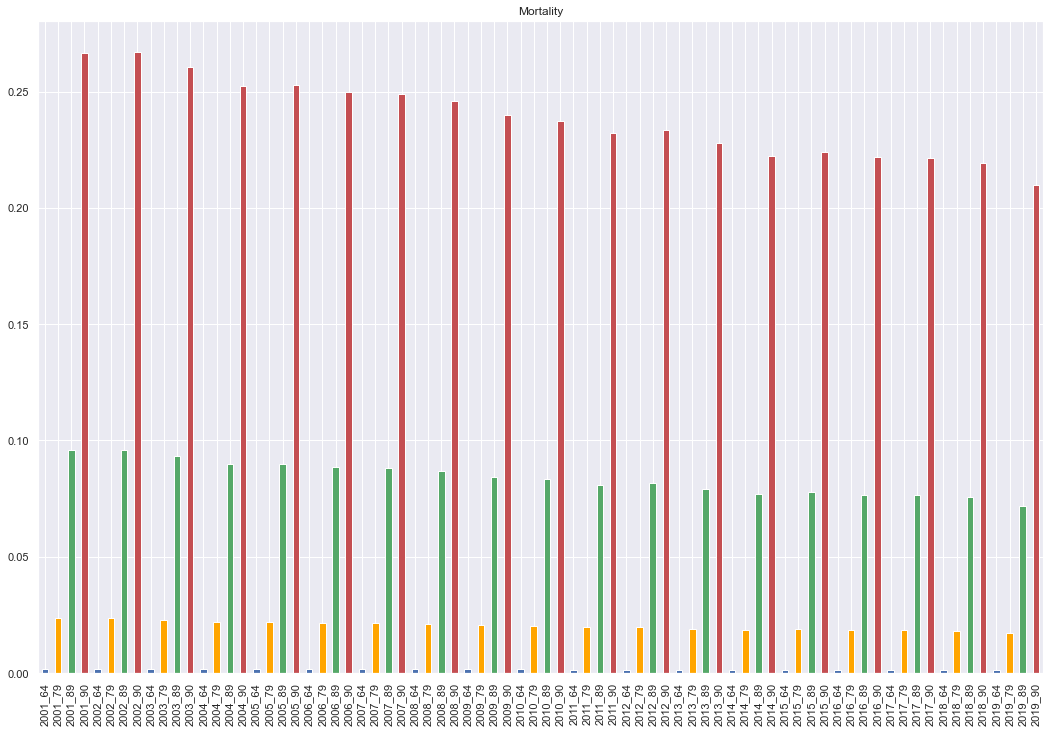

In [285]:
plt.figure(figsize=(18,12))
plt.title('Mortality')
result_p.describe().loc['mean'].plot(kind='bar',color=['b','orange','g','r'])
_= plt.xticks(rotation=90)

In [286]:
abs_pop_no_2020 = strata_abs_pop.loc[2001:2019]
abs_pop_no_2020

,64,79,89,90+
year,,,,
2001,7364484.5,1073089.0,392306.5,66080.0
2002,7392028.5,1066061.0,399119.5,67749.0
2003,7420704.5,1064792.5,403221.5,69510.5
2004,7445736.5,1068657.0,407459.5,71678.0
2005,7469716.0,1075106.0,411296.0,73454.0
2006,7507097.5,1084698.5,413877.0,74831.5
2007,7553167.0,1104317.0,414345.5,76262.5
2008,7592890.0,1134709.5,414587.5,77450.0
2009,7630585.5,1174180.0,414772.5,78976.5


In [287]:
p_means = result_p.describe().loc['mean']
p_means = p_means.reset_index()
p_means[['year','age_grp']] = p_means['index'].str.split('_',1,expand=True)
p_means = pd.pivot(p_means,index='age_grp',columns='year',values='mean')
p_means = p_means.T
p_means.rename(columns={'90' : '90+'},inplace=True)
p_means.index = range(2001,2020)
p_means

age_grp,64,79,89,90+
2001,0.001809,0.023494,0.095839,0.266499
2002,0.001815,0.023563,0.096099,0.267085
2003,0.001754,0.022785,0.093156,0.260415
2004,0.001682,0.021876,0.089696,0.252473
2005,0.001687,0.021930,0.089901,0.252946
2006,0.001658,0.021564,0.088504,0.249711
2007,0.001651,0.021480,0.088182,0.248963
2008,0.001626,0.021153,0.086930,0.246043
2009,0.001573,0.020487,0.084374,0.240040
2010,0.001550,0.020185,0.083211,0.237286


In [288]:
abs_d = p_means * abs_pop_no_2020
abs_d

age_grp,64,79,89,90+
2001,13325.953173,25211.051422,37598.298417,17610.284730
2002,13415.848529,25119.309626,38354.983196,18094.774042
2003,13013.889668,24261.469173,37562.539007,18101.570616
2004,12525.963425,23377.864732,36547.687476,18096.765481
2005,12597.808051,23576.673905,36976.054567,18579.908034
2006,12445.354478,23390.269596,36629.940977,18686.258826
2007,12471.837547,23720.306230,36537.937281,18986.505430
2008,12342.724122,24002.009117,36040.017582,19056.006033
2009,12006.396667,24055.858940,34996.196511,18957.492345
2010,11878.059019,24593.298132,34348.059093,19661.999039


In [289]:
abs_d.sum(axis=1)

2001    93745.587743
2002    94984.915393
2003    92939.468463
2004    90548.281115
2005    91730.444557
2006    91151.823877
2007    91716.586487
2008    91440.756854
2009    90015.944463
2010    90481.415283
2011    89927.854960
2012    91955.680351
2013    90383.025048
2014    88980.006015
2015    90950.229019
2016    90980.784849
2017    91962.016147
2018    92183.896510
2019    88781.891619
dtype: float64

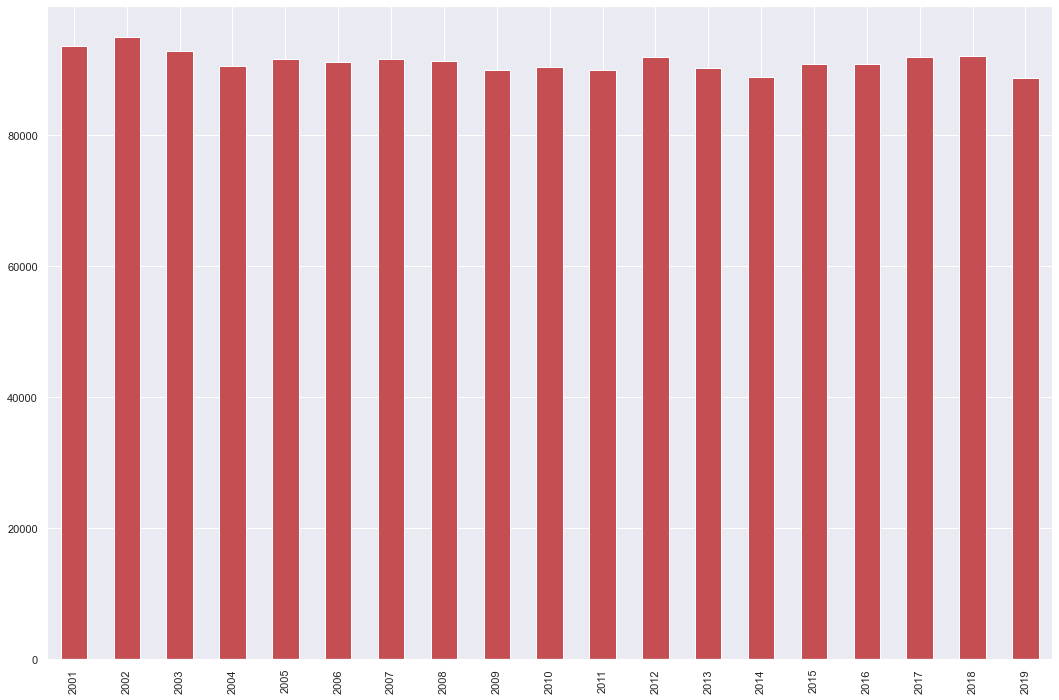

In [290]:
abs_d.sum(axis=1).plot(kind='bar',figsize=(18,12),color='r')

In [291]:
alpha = pm.Normal('alpha', 0, 1 / 1 ** 2,size=4)
beta = pm.Normal('beta',0, 1 /1 ** 2)

std_year = all_data_no_2020['std_year']
age_idx = all_data_no_2020['age_idx']

@pm.deterministic
def lgit(alpha=alpha,beta=beta,age_idx=age_idx-1):
    return np.exp(alpha[age_idx]   + beta * std_year) / (
        1 + np.exp(alpha[age_idx]  + beta * std_year ))

likelihood = pm.Binomial('likelihood',n=all_data_no_2020['pop'],p=lgit,observed=True,value=all_data_no_2020['dead'])

model = pm.Model([alpha,beta,lgit,likelihood])

mcmc = pm.MCMC(model)
sample = mcmc.sample(100000,40000,3)

 [-----------------100%-----------------] 100000 of 100000 complete in 388.3 sec

Plotting alpha_post_0
Plotting alpha_post_1
Plotting alpha_post_2
Plotting alpha_post_3
Plotting beta_post


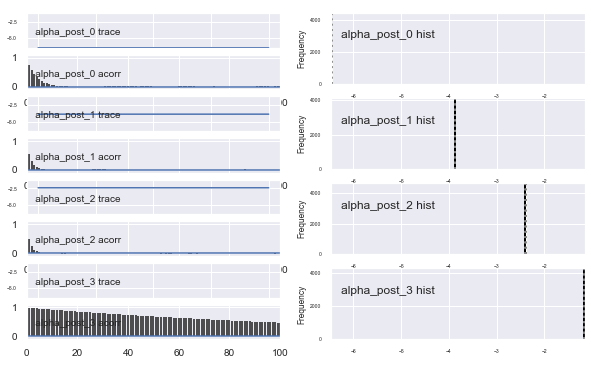

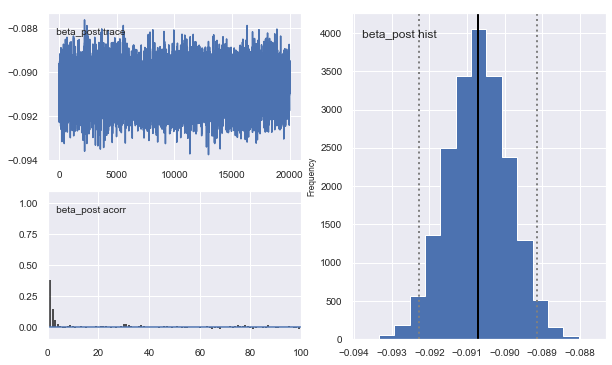

In [292]:
alpha_post = mcmc.trace('alpha')[:]
beta_post = mcmc.trace('beta')[:]

pmplot(alpha_post,'alpha_post')
pmplot(beta_post,'beta_post')

In [293]:
result=pd.DataFrame({'64' : alpha_post[:,0],'79' : alpha_post[:,1],
                    '89' : alpha_post[:,2],'90' : alpha_post[:,3],
                    'beta' : beta_post})

In [294]:
result.describe()


,64,79,89,90,beta
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-6.463073,-3.877280,-2.394523,-1.163062,-0.090705
std,0.002141,0.001479,0.001309,0.001813,0.000809
min,-6.471404,-3.882581,-2.400183,-1.169898,-0.093757
25%,-6.464541,-3.878252,-2.395403,-1.164267,-0.091252
50%,-6.463074,-3.877291,-2.394500,-1.163090,-0.090704
75%,-6.461615,-3.876302,-2.393637,-1.161984,-0.090158
max,-6.453669,-3.871441,-2.388845,-1.156480,-0.087619


In [295]:
result_p = pd.DataFrame()
result_p['64'] = logit_pure(result['64'] + result['beta'])
result_p['79'] = logit_pure(result['79'] + result['beta'])
result_p['89'] = logit_pure(result['89'] + result['beta'])
result_p['90'] = logit_pure(result['90'] + result['beta'])

result_p.describe()

,64,79,89,90
count,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.001423,0.018561,0.076900,0.222049
std,0.000003,0.000031,0.000111,0.000340
min,0.001409,0.018449,0.076457,0.220781
25%,0.001420,0.018540,0.076826,0.221821
50%,0.001423,0.018560,0.076902,0.222046
75%,0.001425,0.018581,0.076976,0.222264
max,0.001438,0.018690,0.077393,0.223409
